# Question 1
## Part 1.1 Implement an agent-based model 

I subdivided the agent-based model into a number of classes:

- Agent: defines an Agent's properties and behaviors when interacting with other Agents.
- AgentGenerator: produces the required number and properties for unpositioned Agents to be used in the Agent-based model.
- AgentMover: Defines a virtual n x n torus grid world and manages positioning and movement of all Agents in the world.
- ABM: generates the model in which all Agents are built, positioned, and managed, as well as captures world metrics for each time step

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

#### Define Agent class

In [1]:
class Agent:
    '''
    Defines an Agent's properties and behaviors 
    when interacting with other Agents.
    
    Fields:
    
        asymptomatic:  True if agent is asymptomatic when infected.
        
        days_infected: How long agent has been infected, if currently infected.
    
        distancing: True if agent is physically distancing.
        
        mask: True if agent is wearing a mask.
        
        position: Location of the Agent in the world, as defined by (x,y).
    
        status: The state of the Agent's health. Allowable statuses are: 
                (R) Recovered
                (S) Susceptible to Infection
                (I) Infected
                (Q) Quarantined     
    '''
    statuses = ['R', 'S', 'I', 'Q'] # allowable statuses
    days_infected = 0
    
    def __init__(self, 
                 position, 
                 status,  
                 mask, 
                 distancing):
        '''
        Initialize an agent.
        '''
        # position (x,y)
        self.position = position

        # status
        if status in self.statuses:
            self.status = status
        else:
            raise ValueError('status: ' + status + ' is not valid.')

        # possibly asymptomatic if infected
        if status == 'I':
            if self.is_asymptomatic():
                 self.asymptomatic = True
            else:
                self.asymptomatic = False
        else:
            self.asymptomatic = False 
                            
        self.mask = mask
        self.distancing = distancing 
        
    
    def is_event(self, num_event, num_outcomes):
        '''
        If an event has a 25% chance, num_event = 1 and num_outcomes = 4
        Returns true if event is selected from outcomes, False otherwise.
        '''
        return random.randint(1,num_outcomes) <= num_event
    
    
    def is_infected(self, adjacent_agents):
        '''
        Returns True if the agent is now infected, given whether
        an adjacent agent is infected or masked and whether the 
        agent is masked. False otherwise.
        
        Check is performed for each agent adjacent to this agent. 
        ''' 
        infected = False
        
        # perform check for all adjacent agents
        for adjacent in adjacent_agents:
        
            # chance of infection if an adjacent agent is infected
            if adjacent.status == 'I':

                # infection probability depends on mask status of both
                if self.mask and adjacent.mask: 

                    if self.is_event(1,10000): # 0.01% chance
                        infected = True

                elif self.mask or adjacent.mask: 

                    if self.is_event(1,100):  # 1% chance
                        infected = True

                else:  

                    if self.is_event(1,4):   # 25% chance
                        infected = True
            
        return infected
            
    
    def is_asymptomatic(self):
        '''
        Returns True if agent is asymptomatic, False otherwise.
        '''
        return self.is_event(1,5) # 20% chance of being asymptomatic
        
    
    def will_quarantine(self):
        '''       
        Returns True if the agent has been infected for 
        at least 3 days and is symptomatic, False otherwise.
        '''       
        return self.days_infected > 2 and not self.asymptomatic

        
    
    def infection_over(self):
        '''
        Returns True if the agent has been infected for at
        least 15 days, False otherwise
        '''
        return self.days_infected > 14
                
    
    def update_status(self, adjacent_agents):
        '''
        Checks whether modification to the agent's status 
        is needed, and updates the status as necessary.
        '''
        
        if self.status == 'S': # not yet infected
            
            if self.is_infected(adjacent_agents):
                self.status = 'I'
                
        elif self.status == 'I': # already infected
            
            if self.will_quarantine():
                self.status = 'Q'
        
            if self.infection_over():
                self.status = 'R'
                
        elif self.status == 'Q': # already in quarantine
            
            if self.infection_over():
                self.status = 'R'
            
            
    def update_agent(self, adjacent_agents):
        '''
        Updates agent metrics based on adjacent agents.
        Does not update position.
        '''
        
        # update days infected if already infected
        if self.status == 'I' or self.status == 'Q':
            self.days_infected += 1 # day passed since infection started            
        
        # update status
        status_before = self.status
        self.update_status(adjacent_agents)
        
         # if now infected, determine if asymptomatic
        if status_before != 'I' and self.status == 'I':
            self.asymptomatic = self.is_asymptomatic()
            
        elif status_before != 'R' and self.status == 'R':
            
            # reset metrics related to infection
            self.days_infected = 0
            self.asymptomatic = False
            
    
    def __str__(self):  
        return  'Agent{'+'position:'+ str(self.position)+', status:'+ str(self.status)+', mask:'+ str(self.mask)+', distancing:'+ str(self.distancing)+', days_infected:'+ str(self.days_infected)+', asymptomatic:'+ str(self.asymptomatic)+'}'      
    
    
    def has_died(self):
        '''
        Return True if agent dies due to infection, False otherwise.
        '''  
        infected = self.status == 'I' or self.status == 'Q'
        return infected and self.is_event(2,1000) #0.2% chance
    

#### Test Agent class

In [287]:
print("Test constructor")
a1 = Agent((1,1), 'I', mask=True, distancing=True)
print(a1)

# check provided parameters
assert a1.position == (1,1)
assert a1.status == 'I'
assert a1.mask == True
assert a1.distancing == True
assert a1.days_infected == 0


# check derived parameters
num = 100000
counter = 0
for i in range(num):
    a1 = Agent((1,1), 'I', mask=True, distancing=True)
    if a1.asymptomatic == True:
        counter += 1
assert round(counter/num,2) == 0.20

Test constructor
Agent{position:(1, 1), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:True}


In [288]:
print('Test is_event()')
a1 = Agent((1,1), 'I', mask=True, distancing=True)

num = 100000
counter = 0
for i in range(num):
    if a1.is_event(1,10000):
        counter += 1
assert round(counter/num,4) == 0.0001, 'Failed with ' + str(round(counter/num,4))

counter = 0
for i in range(num):
    if a1.is_event(1,100):
        counter += 1
assert round(counter/num,2) == 0.01

counter = 0
for i in range(num):
    if a1.is_event(1,4):
        counter += 1
assert round(counter/num,2) == 0.25

counter = 0
for i in range(num):
    if a1.is_event(2,1000):
        counter += 1
assert round(counter/num,3) == 0.002, 'Failed with ' + str(round(counter/num,3))

Test is_event()


In [289]:
print('Test is_asymptomatic()')

counter = 0
for i in range(num):
    if a1.is_asymptomatic():
        counter += 1
assert round(counter/num,2) == 0.20

Test is_asymptomatic()


In [290]:
print('Test will_quarantine()')

a2 = Agent((0,1), 'I', mask=True, distancing=True)

# possibility of quarantine when symptomatic
a2.asymptomatic = False

a2.days_infected = 2
assert a2.will_quarantine() == False

a2.days_infected = 3
assert a2.will_quarantine() == True

a2.days_infected = 4
assert a2.will_quarantine() == True


# when asymptomatic, will not quarantine
a2.asymptomatic = True
a2.days_infected = 2
assert a2.will_quarantine() == False

a2.days_infected = 3
assert a2.will_quarantine() == False

a2.days_infected = 4
assert a2.will_quarantine() == False


Test will_quarantine()


In [291]:
print('Test infection_over()')
a3 = Agent((0,1), 'I', mask=True, distancing=True)
a3.days_infected = 13
assert a3.infection_over() == False

a3.days_infected = 14
assert a3.infection_over() == False

a3.days_infected = 15
assert a3.infection_over() == True


Test infection_over()


In [292]:
print('Test is_infected()')
a1 = Agent((1,1), 'S', mask=True, distancing=True)
a2 = Agent((0,1), 'I', mask=True, distancing=True)

# test 1 adjacent, 1 infected, both masked
a1.mask = True
a2.mask = True
num = 100000
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,4) == 0.0001, round(counter/num,4)

# test 1 adjacent, 1 infected, only agent masked
a1.mask = True
a2.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,2) == 0.01

# test 1 adjacent, 1 infected, only adjacent masked
a1.mask = False
a2.mask = True
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,2) == 0.01

# test 1 adjacent, 1 infected, no masks
a1.mask = False
a2.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2]):
        counter += 1
assert round(counter/num,2) == 0.25

Test is_infected()


In [293]:
print('Test is_infected()')
a3 = Agent((1,2), 'R', mask=True, distancing=True)

# test 2 adjacent, 1 infected, all masked
a1.mask = True
a2.mask = True
a3.mask = True
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
assert round(counter/num,4) == 0.0001

# test 2 adjacent, 1 infected, only agent masked
a1.mask = True
a2.mask = False
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
assert round(counter/num,2) == 0.01

# test 2 adjacent, 1 infected, no one masked
a2.mask = False
a3.mask = False
a1.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
assert round(counter/num,2) == 0.25

Test is_infected()


In [294]:
print('Test is_infected()')
# test 2 adjacent, 2 infected, all masked
a3.status = 'I'
a1.mask = True
a2.mask = True
a3.mask = True
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,4))
assert round(counter/num,4) > 0.0001, 'Failed with ' + str(round(counter/num,4))

# test 2 adjacent, 2 infected, agent masked
a3.status = 'I'
a1.mask = True
a2.mask = False
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,2))
assert round(counter/num,2) > 0.01

# test 2 adjacent, 2 infected, agent masked, one adjacent masked
a3.status = 'I'
a1.mask = True
a2.mask = True
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,2))
assert round(counter/num,2) >= 0.01

# test 2 adjacent, 2 infected, no one masked
a3.status = 'I'
a1.mask = False
a2.mask = False
a3.mask = False
counter = 0
for i in range(num):
    if a1.is_infected([a2,a3]):
        counter += 1
print(round(counter/num,2))
assert round(counter/num,2) > 0.25

Test is_infected()
0.0002
0.02
0.01
0.44


In [295]:
print('Test update_status()')
a1 = Agent((1,1), 'R', mask=True, distancing=True)
a2 = Agent((0,1), 'I', mask=False, distancing=True)

# test R status
print('Test R status...')
a1.update_status([a2])
assert a1.status == 'R'

# test I status
print('Test I status...')

a1.status = 'I'
a1.days_infected = 0 # test not yet quarantined
a1.asymptomatic = True
a1.update_status([a2])  
assert a1.status == 'I'


a1.status = 'I'
a1.days_infected = 3 # test change to quarantined
a1.asymptomatic = False
a1.update_status([a2]) 
assert a1.status == 'Q'

a1.status = 'I'
a1.days_infected = 15 # test change to recovered
a1.asymptomatic = False
a1.update_status([a2]) 
assert a1.status == 'R'

# test Q status
print('Test Q status...')
a1.status = 'Q'
a1.days_infected = 15 # test change to recovered
a1.asymptomatic = False
a1.update_status([a2]) 
assert a1.status == 'R'

# test S status
print('Test S status...')
a1.status = 'S'
a1.days_infected = 0
a1.asymptomatic = False
num = 10000
counter = 0
for i in range(num):
    a1.status = 'S'
    a1.update_status([a2])
    if a1.status == 'I':
        counter += 1
assert round(counter/num,2) == 0.01

Test update_status()
Test R status...
Test I status...
Test Q status...
Test S status...


In [296]:
print('Test update_agent()')

a1 = Agent((1,1), 'R', mask=False, distancing=True)
a2 = Agent((0,1), 'I', mask=False, distancing=True)


# check days_infected
a1.status = 'I'
a1.update_agent([a2])
assert a1.days_infected == 1

# check status if now recovered
# check metrics if now recovered
a1.status = 'I'
a1.days_infected = 14
a1.update_agent([a2])
assert a1.status == 'R'
assert a1.days_infected == 0
assert a1.asymptomatic == False

# check status if now recovered
# check metrics if now recovered
a1.status = 'Q'
a1.days_infected = 14
a1.update_agent([a2])
assert a1.status == 'R'
assert a1.days_infected == 0
assert a1.asymptomatic == False
    

# check asymptomatic if now infected
a1.status = 'S'
a1.days_infected = 0
a1.asymptomatic = False
a1.update_agent([a2])

num = 100000
counter = 0
for i in range(num):
    a1.status = 'S'
    a1.asymptomatic = False
    a1.update_agent([a2])
    if a1.asymptomatic == True:
        counter += 1
assert round(counter/num,2) == 0.05

Test update_agent()


In [4]:
print('Test has_died()')
num = 100000

# check for infected status
a2 = Agent((0,1), 'I', mask=False, distancing=True)
counter = 0
for i in range(num):
    if a2.has_died():
        counter += 1
assert round(counter/num,3) == 0.002

a2 = Agent((0,1), 'Q', mask=False, distancing=True)
counter = 0
for i in range(num):
    if a2.has_died():
        counter += 1
assert round(counter/num,3) == 0.002


# check if status not infected
a3 = Agent((0,1), 'S', mask=False, distancing=True)
counter = 0
for i in range(num):
    if a3.has_died():
        counter += 1
assert round(counter/num,1) == 0.0

Test has_died()


In [298]:
print('All tests pass for Agent class.')

All tests pass for Agent class.


#### Define AgentGenerator class

In [12]:
class AgentGenerator:
    '''  
    Defines functionality for generating the required 
    number of Agents which match specified properties
    (i.e. the correct number of infected, distancing, 
    masked, vaccinated).
    
    Mask and distancing properties are set independent of each other.
    - Agents are randomly chosen among infected and vaccinated when 
      deciding which Agents are masked.
    - Agents are randomly chosen among infected and vaccinated when 
      deciding which Agents are distancing.
      
    Fields:
    
        m: the number of Agents to be generated
        
        num_distancing: the number of Agents which have distancing=True property at the start
        
        num_infected: the number of Agents set as infected at the start
        
        num_mask: the number of Agents which are masked at the start
        
        num_vaccinated: the number of Agents which are in a recovered state at the start
    '''
    
    
    def __init__(self, m, num_infected, percent_distancing, percent_mask, percent_vaccinated = 0.0):
        '''
        Sets the number of distancing, masked, and vaccinated Agents
        which will be generated by generate_agents().
        '''        
        # capture parameters
        self.m = m
        self.num_infected = num_infected

        # set discrete numbers for distancing, mask, vaccinated
        self.num_distancing = int(round(percent_distancing*m))
        self.num_mask = int(round(percent_mask*m))
        self.num_vaccinated = int(round(percent_vaccinated*m))
        
        # validation checks        
        if self.num_infected + self.num_vaccinated > m:
            raise ValueError('not allowed to have (infected + vaccinated) > total number of agents')
    
    
    def is_infected(self, current_infected):
        '''
        Given the current number of infected Agents, returns True 
        if there should be more infected agents in order to
        reach the required number of infected Agents.
        Returns False otherwise.
        '''
        return current_infected < self.num_infected
    
    
    def is_vaccinated(self,infected,current_vaccinated):
        '''
        Given the current number of vaccinated Agents and
        whether this Agent is infected, returns True if 
        the agent is not infected and there should be 
        more vaccinated agents to reach the required
        number of vaccinated Agents.
        Returns False otherwise.
        '''
        if infected:
            return False # can't be both infected and vaccinated
        else: 
            return current_vaccinated < self.num_vaccinated
    
    
    def get_status(self, infected, vaccinated):
        '''
        Used to help determine which status should be chosen.
        
        If infected, returns 'I'.
        If vaccinated, returns 'R'.
        If neither infected nor vaccinated, returns 'S'.
        Raises a ValueError if Agent is both infected
        and vaccinated (not allowed in this model).
        '''
        if infected and vaccinated:
            raise ValueError('Agent is not allowed to be both infected and vaccinated.')
        
        if infected:
            status = 'I'
        elif vaccinated:
            status = 'R'
        else:
            status = 'S'
        
        return status
    

    def select_indexes(self, p):
        '''
        Selects p random positions between 0 and m-1. 
        '''
    
        chosen = list()
        for i in range(p):
            
            position = random.randint(0,self.m-1)
            while position in chosen:
                
                # try again
                position = random.randint(0,self.m-1)
            
            chosen.append(position)
        return chosen


    def generate_agents(self):
        '''
        Creates and returns a list of m agents, each created with 
        a randomly chosen position from the n x n grid, with the 
        required number of agents selected as infected and vaccinated.
        
        After setting status, randomly selects agents to be masked.
        Separately from mask, randomly selects agents to be distancing.
        '''
        
        # create agents
        agents = list()
        
        # set counters
        current_infected = 0
        current_vaccinated = 0
        
        # randomly select indexes for mask and distancing
        mask_indexes = self.select_indexes(self.num_mask)
        distancing_indexes =  self.select_indexes(self.num_distancing)
        
        for i in range(self.m):
        
            # select if agent is infected
            infected = self.is_infected(current_infected)
            if infected:
                current_infected += 1
            
            # select if agent is vaccinated
            vaccinated = self.is_vaccinated(infected, current_vaccinated)
            if vaccinated:
                current_vaccinated += 1
                
            # set status
            status = self.get_status(infected, vaccinated)

            # set values for mask and distancing
            mask = i in mask_indexes
            distancing = i in distancing_indexes
                
            # position will be set later
            new_agent = Agent((-1,-1), status, mask=mask, distancing=distancing)
            agents.append(new_agent)          
        
        return agents
    

#### Testing AgentGenerator class

In [300]:
print('Test constructor')

# test version with defined percent_vaccinated
ag = AgentGenerator(100,10,0.25,0.35,0.45)
assert ag.m == 100
assert ag.num_infected == 10
assert ag.num_distancing == 25
assert ag.num_mask == 35
assert ag.num_vaccinated == 45

# test version without defined percent_vaccinated
ag = AgentGenerator(100,10,0.25,0.35)
assert ag.m == 100
assert ag.num_infected == 10
assert ag.num_distancing == 25
assert ag.num_mask == 35
assert ag.num_vaccinated == 0

Test constructor


In [301]:
print('Test is_infected()')

ag = AgentGenerator(100,1,0.25,0.35,0.45)
current_infected = 0
infected = ag.is_infected(current_infected)
assert infected == True

current_infected = 1
infected = ag.is_infected(current_infected)
assert infected == False

Test is_infected()


In [302]:
print('Test is_vaccinated()')

ag = AgentGenerator(100,1,0.25,0.35,0.45)

# infected should not become vaccinated
current_vaccinated = 0
infected = True
vaccinated = ag.is_vaccinated(infected,current_vaccinated)
assert vaccinated == False


# remaining should become vaccinated
current_vaccinated = 0
infected = False
vaccinated = ag.is_vaccinated(infected,current_vaccinated)
assert vaccinated == True

# full should not become vaccinated
current_vaccinated = 45
infected = False
vaccinated = ag.is_vaccinated(infected,current_vaccinated)
assert vaccinated == False



Test is_vaccinated()


In [10]:
print('Test get_status()')
ag = AgentGenerator(100,1,0.25,0.35,0.45)

# infected
infected = True
vaccinated = False
status = ag.get_status(infected, vaccinated)
assert status == 'I'

# vaccinated
infected = False
vaccinated = True
status = ag.get_status(infected, vaccinated)
assert status == 'R'

# susceptible
infected = False
vaccinated = False
status = ag.get_status(infected, vaccinated)
assert status == 'S'


# error handling
try:
    infected = True
    vaccinated = True
    status = ag.get_status(infected, vaccinated)
    assert False
except ValueError:
    assert True

Test get_status()


In [13]:
print('Test select_indexes()')

m = 100
ag = AgentGenerator(m,1,0.25,0.35,0.45)

num_positions = 25
positions = ag.select_indexes(num_positions)

assert len(positions) == num_positions
assert len(set(positions)) == num_positions

counter = 0
for p in positions:
    if p >= m or p < 0: # should be within [0...m-1] index positions
        counter += 1
assert counter == 0
print(positions)

Test select_indexes()
[27, 87, 48, 4, 92, 54, 0, 94, 62, 39, 38, 89, 97, 6, 35, 20, 60, 21, 31, 53, 33, 37, 7, 46, 14]


In [305]:
print('Test create_agents()')
m = 100
ag = AgentGenerator(m,10,0.25,0.35,0.45)
agents = ag.generate_agents()

assert len(agents) == m

infected_counter = 0
vaccinated_counter = 0
susceptible_counter = 0
mask_counter = 0
distancing_counter = 0

for agent in agents:
    if agent.status == 'I':
        infected_counter += 1
    elif agent.status == 'R':
        vaccinated_counter += 1
    elif agent.status == 'S':
        susceptible_counter += 1
        
    if agent.mask:
        mask_counter += 1
    
    if agent.distancing:
        distancing_counter += 1

assert infected_counter == 10, infected_counter
assert distancing_counter == 25, distancing_counter
assert mask_counter == 35, mask_counter
assert vaccinated_counter == 45, vaccinated_counter
assert susceptible_counter == m - infected_counter - vaccinated_counter, susceptible_counter


Test create_agents()


In [306]:
print('All tests pass for AgentGenerator class.')

All tests pass for AgentGenerator class.


#### Define AgentMover class
Class must consider how wrapping around the torus grid works, as shown below.

![02718-HW4-Wrap.png](images/02718-HW4-Wrap.png)

The grid space which must be considered while moving an agent can be limited to a region 3 units from the agent's current position, as shown below.

![02718-HW4-Moves.png](images/02718-HW4-Moves.png)

Available moves may be restricted depending on whether nearby agents are distancing and whether this agent is distancing. The restrictions turn out to be exactly the same.

Restrictions if nearby agents are distancing

![02718-HW4-OtherDistancing.png](images/02718-HW4-OtherDistancing.png)

Restrictions if this agent is distancing

![02718-HW4-SelfDistancing.png](images/02718-HW4-SelfDistancing.png)

In [23]:
class AgentMover:
    '''
    Defines a virtual n x n torus grid world and 
    manages the positioning and movement of all 
    Agents in this world.
    
    Fields:
    
        n: the dimension of the square torus grid
           used to define the world in which Agents
           move
    '''
    
    # allowable moves
    directions = [[-1, 0], # left
                  [ 1, 0], # right
                  [ 0,-1], # up
                  [ 0, 1], # down
                  [-1,-1], # left & up
                  [-1, 1], # left & down
                  [ 1,-1], # right & up
                  [ 1, 1]] # right & down
    
    # all moves which extend 3 positions from current position (0,0)
    directions_dia_3 = [[i,j] for i in range(-3,4) for j in range (-3,4) if (i,j) != (0,0)]
    
    # all moves which extend 2 positions from current position (0,0)
    directions_dia_2 = [[i,j] for i in range(-2,3) for j in range (-2,3) if (i,j) != (0,0)]
    
    def __init__(self, n):
        self.n = n
        

    def get_random_position(self, selected):
        '''
        Returns a random (i,j) position in an n x n grid 
        which has not yet been selected.
        '''
        
        # try random position
        i = random.randint(0,self.n-1)
        j = random.randint(0,self.n-1)
        
        while (i,j) in selected:

            # keep trying if position has already been chosen
            i = random.randint(0,self.n-1)
            j = random.randint(0,self.n-1)
            
        return (i,j)
    
    
    def split_agents(self, agents):
        '''
        Splits agents into those which are distancing and other. 
        Returns tuple of two lists:(distancing agents, other agents)
        '''
        
        # position distancing agents first
        distancing_agents = list()
        other_agents = list()
        
        for agent in agents:
            if agent.distancing:
                distancing_agents.append(agent)
            else:
                other_agents.append(agent)
                
        return distancing_agents, other_agents
    
        
    def get_x(self, x_curr, change):
        '''
        Calculates next x coordinate, wrapping around torus 
        grid if position would move off the top or bottom.
        '''
        
        x_result = x_curr + change
        if x_result < 0:
            x_next = self.n + x_result
        elif x_result > self.n-1:
            x_next = x_result % self.n
        else:
            x_next = x_result
                
        return x_next
 

    def get_y(self, y_curr, change):
        '''
        Calculates next y coordinate, wrapping around torus 
        grid if position would move off the left or right.
        '''                       
        return self.get_x(y_curr, change) # works the same as x changes

    
    def get_adj_positions(self, position):
        '''
        Returns a set of all 8 positions which surround the given position, 
        wrapping around the torus grid when necessary.
        '''

        adjacent = set()
        
        x_curr = position[0]
        y_curr = position[1]
        
        for x_change,y_change in self.directions:
            
            # get resulting coordinates after change
            x_next = self.get_x(x_curr, x_change)
            y_next = self.get_y(y_curr, y_change)
        
            adjacent.add((x_next, y_next))
        
        return adjacent
    
    
    def get_search_space(self, position, directions_set):
        '''
        Returns a set of all positions which surround the given position, 
        representing all moves within the directions set, and 
        wrapping around the torus grid when necessary.
        
        For a directions set of diameter 3, there are 48 positions.
        For a directions set of diameter 2, there are 24 positions.
        For a directions set of diameter 1, there are 8 positions.
        '''
        
        adjacent = set()
        
        x_curr = position[0]
        y_curr = position[1]
        
        for x_change,y_change in directions_set: 
                
            # get resulting coordinates after change
            x_next = self.get_x(x_curr, x_change)
            y_next = self.get_y(y_curr, y_change)

            adjacent.add((x_next, y_next))
        
        return adjacent
    
    
    def positions_available(self, unavailable, agents, positioned):
        '''
        Returns True if there is at least one position 
        available for each agent not yet positioned.
        '''
        
        num_agents_left = len(agents) - positioned
        num_positions_left = self.n * self.n - len(unavailable)
        return num_positions_left >= num_agents_left
    
    
    def position_distancing_agents(self, distancing_agents):
        '''
        Attempts to find unique positions for given list of distancing agents 
        such that every agent maintains at least one position between itself
        and every other agent. 
        
        Returns (True, unavailable) if such a positioning 
        is found. Returns (False, unavailable) otherwise. 
        
        unavailable is a set containing all positions which 
        can not be selected for agents.
        '''
                   
        # reset for new attempt
        unavailable = set()
        num_positioned = 0

        for agent in distancing_agents: 
            
            # if there aren't enough available positions left, start over
            if not self.positions_available(unavailable, distancing_agents, num_positioned):
                return (False, unavailable)           
        
            # choose available position
            position = self.get_random_position(unavailable)
            agent.position = position

            # update available positions
            curr_unavailable = self.get_adj_positions(position) # positions surrounding are not available
            curr_unavailable.add(position)                      # position taken is not available
            unavailable = unavailable.union(curr_unavailable)   # update full list
        
            # update counter
            num_positioned += 1
        
        # all agents were positioned successfully
        return (True, unavailable)
    
    
    def position_remaining_agents(self, agents, unavailable):
        '''
        Positions all agents without distancing requirements.
        Returns True if agents were positioned successfully,
        False otherwise.
        '''
        
        num_positioned = 0
        for agent in agents:
            
            # only continue if there are enough positions left
            if not self.positions_available(unavailable, agents, num_positioned):
                return False
        
            # choose available position
            position = self.get_random_position(unavailable)
            agent.position = position

            # update available positions                     
            unavailable.add(position)
        
            # update counter
            num_positioned += 1
        
        # all agents were positioned successfully
        return True
        

    def find_nearby_agents(self, agents, position):
        '''
        Finds all agents within 3 spaces of this agent in every direction.
        This reduces the search space for available positions to only
        those agents which may be affected by this agent after a move.
        
        The diagram above explains why a diameter of 3 is used.
        '''
        # determine positions within 3 spaces of this agent
        search_space = self.get_search_space(position, self.directions_dia_3)
        
        # find all agents within that search space
        nearby = list()
        for agent in agents:
            if agent.position in search_space:
                nearby.append(agent)
        
        return nearby
    
    
    def remove_position_if_occupied(self, other, avail):
        '''
        If position of other agent is in available positions,
        removes it.
        '''
        
        if other.position in avail:
            avail.remove(other.position)
     
    
    def remove_positions_distancing_others(self, other, avail):
        '''
        If other agent is distancing, removes all positions
        adjacent to other agent from available positions.
        '''
        
        # restrictions depend on distancing of agent and other
        if other.distancing:
            
            # all positions within 1 space of other are unavailble
            other_adj = self.get_adj_positions(other.position)
        
            # remove restricted positions
            for pos in other_adj:
                if pos in avail:
                    avail.remove(pos)
    
    
    def remove_positions_distancing_self(self, agent, other, avail):
        '''
        If this agent is distancing, removes all positions
        which would breach distancing due to proximity
        of other agent.
        '''
        
        if agent.distancing:
            
            # all positions within 1 space of other are unavailable
            other_adj = self.get_adj_positions(other.position)
        
            # remove restricted positions
            for pos in other_adj:
                if pos in avail:
                    avail.remove(pos)
        
           
    def get_available_positions(self, agent, agents):
        '''
        Returns a list of possible positions to which a
        given agent can move, given the other agents.
        
        Constrained by the current position of other agents
        and whether another agent is distancing.
        
        determine which of those positions are:
         1 - not occupied
         2 - allow this agent to maintain its own distancing boundaries if necessary
         3 - outside distancing boundaries of another agent
        '''               
        # if no nearby agents, all positions available
        avail = self.get_adj_positions(agent.position)
                
        # find all nearby agents
        nearby = self.find_nearby_agents(agents, agent.position)

        # if there are nearby agents, determine availability
        if nearby:

            # check moves against each nearby agent
            for other in nearby:

                # remove occupied positions
                self.remove_position_if_occupied(other, avail)
                
                # remove positions which breach distancing of others
                self.remove_positions_distancing_others(other, avail)
                
                # remove positions which breach distancing of this agent
                self.remove_positions_distancing_self(agent,other,avail)
                    
        return avail      
        
       
    def move_agent(self, agent, positions):
        '''
        Selects a random position from positions and 
        updates the agent to be at that location.
        
        If positions list is empty, does not move
        the agent.
        '''
        if positions:
            i = random.randint(0,len(positions)-1) # random index
            agent.position = list(positions)[i]     
        
      
    def move_all_agents(self, agents):
        '''
        Selects and moves each agent in agents.
        '''
        for agent in agents:
            moves = self.get_available_positions(agent, agents)
            self.move_agent(agent, moves)
            
            
    def check_position_conflicts(self, agents):
        '''
        Returns a set of positions which contain
        more than one agent.
        
        Used for testing purposes.
        '''
        
        conflicts = set()
        chosen = dict()
        for agent in agents:
            pos = agent.position
            if pos in chosen:
                chosen[pos] +=1 # increment value of key by 1
            else:
                chosen[pos] = 1 # add key to dictionary
        
        for key in chosen.keys():
            if chosen[key] > 1:
                conflicts.add(key) # more than 1 Agent here
         
        return conflicts
        
        
    def check_distancing_conflicts(self, agents):
        '''
        Returns a set of positions which contain
        agents that breach distancing constraints.
        
        Used for testing purposes.
        '''
        
        conflicts = set()
        
        for agent in agents:
            
            if agent.distancing:
                                
                pos = agent.position
                adj = self.get_adj_positions(pos)
                
                # no other agent should be in an adjacent position
                
                # Note agent won't conflict with itself because its
                # position is not in adj
                for each in agents:
                    
                    # check whether any agent is within the distancing range
                    if each.position in adj:
                        conflicts.add(each.position)
        
        return conflicts
    
    
    def position_agents(self, agents):
        '''
        Positions given agents on n x n grid, following distancing 
        constraints for distancing agents. Performs multiple 
        positioning attempts until either a solution is found or
        the number of allowed attempts is exhausted.
        
        Returns True if positioning is found.
        
        Raises ValueError if no viable positioning is found 
        after all attempts. 
        '''

        # split agents into distancing and other
        distancing_agents, other_agents = self.split_agents(agents)
        attempt_counter_outer = 0
        all_success = False

        # both distancing and other agents must be positioned
        while all_success == False:

            # reset for next attempt
            unavailable = set()
            d_success = False
            attempt_counter_inner = 0

            # attempt to position distancing agents first
            while d_success == False:

                d_success, unavailable = self.position_distancing_agents(distancing_agents)

                attempt_counter_inner += 1
                if attempt_counter_inner >= 10:
                    raise ValueError('Unable to find positions for all distancing agents')           
            
            # position remaining agents after successful positioning of distancing agents
            all_success = self.position_remaining_agents(other_agents, unavailable)

            attempt_counter_outer += 1
            if attempt_counter_outer >= 100:
                remaining = self.n * self.n - len(unavailable)
                raise ValueError('Unable to find positions for other agents:',remaining)

        # all agents positioned
        return True
    
    

#### Test AgentMover class

In [308]:
print('Test position_agents()')

# success
n=25
am = AgentMover(n)
a1 = Agent((-1,-1), 'I', mask=True, distancing=True)
a2 = Agent((-1,-1), 'I', mask=True, distancing=False)
agents = [a1,a2]

assert am.position_agents(agents) == True
for each in agents:
    print(each)
    assert each.position != (-1,-1)
    
# failure
n=1
am = AgentMover(n)
a1 = Agent((-1,-1), 'I', mask=True, distancing=True)
a2 = Agent((-1,-1), 'I', mask=True, distancing=False)
agents = [a1,a2]

try:
    am.position_agents(agents)
    assert False
except ValueError:
    assert True
    
# try with full number of Agents with no distancing
n=25
am = AgentMover(n)
agents = [Agent((-1,-1), 'I', mask=True, distancing=False) for i in range(250)]
print(len(agents))
result = am.position_agents(agents)
assert result == True
for each in agents:
    assert each.position != (-1,-1)
    
# try with 10% distancing
n=25
am = AgentMover(n)
ag = AgentGenerator(250,10,0.1,0.35,0.45)
agents = ag.generate_agents()
result = am.position_agents(agents)
assert result == True
for each in agents:
    assert each.position != (-1,-1)
    
# try with 50% distancing
n=25
am = AgentMover(n)
ag = AgentGenerator(250,10,0.20,0.35,0.45)
agents = ag.generate_agents()
result = am.position_agents(agents)
assert result == True
for each in agents:
    assert each.position != (-1,-1)

Test position_agents()
Agent{position:(11, 10), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:False}
Agent{position:(12, 7), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}
250


In [309]:
print('Test get_random_position()')
n=25
am = AgentMover(n)

selected = list()
position = am.get_random_position(selected)

# check if position is within n x n grid
assert position[0] >= 0
assert position[0] < n
assert position[1] >= 0
assert position[1] < n

# check if position has been taken already
# create list with all positions taken except (0,0)
selected = [(i,j) for i in range(n) for j in range(n) if (i,j) != (0,0) ]
position = am.get_random_position(selected)
assert position == (0,0)

Test get_random_position()


In [310]:
print('Test split_agents()')
n=25
am = AgentMover(n)

a1 = Agent((1,2), 'I', mask=True, distancing=True)
a2 = Agent((1,2), 'I', mask=True, distancing=True)
a3 = Agent((1,2), 'R', mask=True, distancing=False)
a4 = Agent((1,2), 'R', mask=True, distancing=False)
a5 = Agent((1,2), 'R', mask=True, distancing=False)

distancing_agents, other_agents = am.split_agents([a1,a2,a3,a4,a5])

for agent in distancing_agents:
    assert agent.status == 'I'
    
for agent in other_agents:
    assert agent.status == 'R'
    
assert len(distancing_agents) == 2
assert len(other_agents) == 3

Test split_agents()


In [311]:
print('Test get_x()')

n=25
am = AgentMover(n)

# move 1 space
assert am.get_x(0,-1) == n-1
assert am.get_x(0,1) == 1
assert am.get_x(n-1,1) == 0

# move 2 spaces
assert am.get_x(0,-2) == n-2
assert am.get_x(0,2) == 2
assert am.get_x(n-1,2) == 1

Test get_x()


In [312]:
print('Test get_y()')

n=25
am = AgentMover(n)

# move 1 space
assert am.get_y(0,-1) == n-1
assert am.get_y(0,1) == 1
assert am.get_y(n-1,1) == 0

# move 2 spaces
assert am.get_y(0,-2) == n-2
assert am.get_y(0,2) == 2
assert am.get_y(n-1,2) == 1

Test get_y()


In [313]:
print('Test get_adj_positions()')

n=25
am = AgentMover(n)

# non-edge position
current_position = (1,1)
adjacent_correct = [(0,0),(0,1),(0,2),
                    (1,0),(1,2),
                    (2,0),(2,1),(2,2)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'


# lower right corner
current_position = (24,24)
adjacent_correct = [(23,0),(23,23),(23,24),
                    (24,0),(24,23),
                    (0,0),(0,23),(0,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

# upper right corner
current_position = (0,24)
adjacent_correct = [(24,0),(24,23),(24,24),
                    (0,0),(0,23),
                    (1,0),(1,23),(1,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

# lower left corner
current_position = (24,0)
adjacent_correct = [(23,0),(23,1),(23,24),
                    (24,1),(24,24),
                    (0,0),(0,1),(0,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

# upper left corner
current_position = (0,0)
adjacent_correct = [(24,0),(24,1),(24,24),
                    (0,1),(0,24),
                    (1,0),(1,1),(1,24)]
adjacent = am.get_adj_positions(current_position)
print(adjacent)
for each in adjacent_correct:    
    assert each in adjacent, str(each) + ' is missing from result.'

Test get_adj_positions()
{(0, 1), (1, 2), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
{(0, 23), (23, 23), (24, 23), (0, 0), (23, 0), (24, 0), (0, 24), (23, 24)}
{(0, 23), (24, 23), (0, 0), (1, 24), (24, 0), (1, 23), (1, 0), (24, 24)}
{(0, 1), (23, 1), (24, 1), (0, 0), (23, 0), (0, 24), (23, 24), (24, 24)}
{(0, 1), (24, 1), (1, 24), (1, 1), (24, 0), (1, 0), (0, 24), (24, 24)}


In [314]:
print('Test positions_available()')

n=1
am = AgentMover(n)
a1 = Agent((-1,-1), 'I', mask=True, distancing=True)
unavailable = set()

# (unavailable, agents, positioned)
assert am.positions_available(unavailable,[a1],0) == True 

unavailable.add(1)
assert am.positions_available(unavailable,[a1],0) == False


Test positions_available()


In [315]:
print('Test position_distancing_agents()')

# only possible to place one agent
n=3
am = AgentMover(n)
agents = [Agent((-1,-1), 'I', mask=True, distancing=True) for i in range(2)]
result, unavailable = am.position_distancing_agents(agents)
assert result == False


# multiple agents can be placed
n=25
am = AgentMover(n)
agents = [Agent((-1,-1), 'I', mask=True, distancing=True) for i in range(2)]
result, unavailable = am.position_distancing_agents(agents)
assert result == True


Test position_distancing_agents()


In [316]:
print('Test position_remaining_agents()')

n=1
am = AgentMover(n)

a1 = Agent((-1,-1), 'I', mask=True, distancing=False)
a2 = Agent((-1,-1), 'I', mask=True, distancing=False)

unavailable = set()

assert am.position_remaining_agents([a1],unavailable) == True


unavailable.add((0,0))
assert am.position_remaining_agents([a1],unavailable) == False

Test position_remaining_agents()


In [317]:
print('Test get_search_space()')
n=25
am = AgentMover(n)
   

# test 3 diameter, no wrap
position = (5,5)

expected = [(2, 2),(2, 3),(2, 4),(2, 5),(2, 6),(2, 7),(2, 8),
            (3, 2),(3, 3),(3, 4),(3, 5),(3, 6),(3, 7),(3, 8),
            (4, 2),(4, 3),(4, 4),(4, 5),(4, 6),(4, 7),(4, 8),
            (5, 2),(5, 3),(5, 4),       (5, 6),(5, 7),(5, 8),
            (6, 2),(6, 3),(6, 4),(6, 5),(6, 6),(6, 7),(6, 8),
            (7, 2),(7, 3),(7, 4),(7, 5),(7, 6),(7, 7),(7, 8),
            (8, 2),(8, 3),(8, 4),(8, 5),(8, 6),(8, 7),(8, 8)]
actual = am.get_search_space(position,am.directions_dia_3)
for each in expected:
    assert each in actual, 'missing ' + str(each)
    
    
# test 3 diameter, wrap
position = (0,0)

expected = [       (0, 1),(0, 2),(0, 3),       (0, 22),(0, 23),(0, 24),
            (1, 0),(1, 1),(1, 2),(1, 3),       (1, 22),(1, 23),(1, 24),
            (2, 0),(2, 1),(2, 2),(2, 3),       (2, 22),(2, 23),(2, 24),
            (3, 0),(3, 1),(3, 2),(3, 3),       (3, 22),(3, 23),(3, 24),
            
            (22, 0),(22, 1),(22, 2),(22, 3),   (22, 22),(22, 23),(22, 24),
            (23, 0),(23, 1),(23, 2),(23, 3),   (23, 22),(23, 23),(23, 24),
            (24, 0),(24, 1),(24, 2),(24, 3),   (24, 22),(24, 23),(24, 24)]

actual = am.get_search_space(position,am.directions_dia_3)
for each in expected:
    assert each in actual, 'missing ' + str(each)
    


Test get_search_space()


In [318]:
print('Test find_nearby_agents()')
n=25
am = AgentMover(n)
position = (5,5)

# no agent nearby
a1 = Agent((1,1), 'I', mask=True, distancing=False)
result = am.find_nearby_agents([a1], position)
assert len(result) == 0
print(result)
print()

# one agent nearby
a2 = Agent((6,6), 'I', mask=True, distancing=False)
result = am.find_nearby_agents([a1,a2], position)
assert len(result) == 1
for each in result:
    print(each)
print()

# two agents nearby
a3 = Agent((6,7), 'I', mask=True, distancing=False)
result = am.find_nearby_agents([a1,a2,a3], position)
assert len(result) == 2
for each in result:
    print(each)
print()
    
# three agents nearby, wrapped
position = (0,0)
a4 = Agent((24,24), 'I', mask=True, distancing=False)
a5 = Agent((23,23), 'I', mask=True, distancing=False)
a6 = Agent((22,22), 'I', mask=True, distancing=False)
result = am.find_nearby_agents([a4,a5,a6], position)
assert len(result) == 3
for each in result:
    print(each)
print()

Test find_nearby_agents()
[]

Agent{position:(6, 6), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}

Agent{position:(6, 6), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(6, 7), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}

Agent{position:(24, 24), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:True}
Agent{position:(23, 23), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(22, 22), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}



In [319]:
print('Test remove_position_if_occupied()')
n=25
am = AgentMover(n)
available = [(0,0),(1,1)]

# attempt where agent is in available
a1 = Agent((0,0), 'I', mask=True, distancing=True)
am.remove_position_if_occupied(a1, available)

assert (0,0) not in available

# attempt where position not in available
a2 = Agent((1,0), 'I', mask=True, distancing=True)
am.remove_position_if_occupied(a2, available)

assert len(available) == 1


Test remove_position_if_occupied()


In [320]:
print('Test remove_positions_distancing_others()')

n=25
am = AgentMover(n)
a1 = Agent((5,5), 'I', mask=True, distancing=False)
available = [(4, 4), (4, 5), (4, 6), 
             (5, 4),         (5, 6), 
             (6, 4), (6, 5), (6, 6)]



# other agent not distancing
a3 = Agent((3,4), 'I', mask=True, distancing=False)
am.remove_positions_distancing_others(a3, available)
assert len(available) == 8


# other agent distancing
a2 = Agent((3,4), 'I', mask=True, distancing=True)
removed = [(4, 4), (4, 5)]

am.remove_positions_distancing_others(a2, available)
for each in removed:
    assert each not in available

Test remove_positions_distancing_others()


In [321]:
print('Test remove_positions_distancing_self()')

n=25
am = AgentMover(n)
a1 = Agent((5,5), 'I', mask=True, distancing=True)
available = [(4, 4), (4, 5), (4, 6), 
             (5, 4),         (5, 6), 
             (6, 4), (6, 5), (6, 6)]



# other agent not distancing
a3 = Agent((4,8), 'I', mask=True, distancing=False)
am.remove_positions_distancing_self(a1, a3, available)
assert len(available) == 8


# other agent distancing
a2 = Agent((3,4), 'I', mask=True, distancing=False)
removed = [(4, 4), (4, 5)]

am.remove_positions_distancing_self(a1, a2, available)
for each in removed:
    assert each not in available

Test remove_positions_distancing_self()


In [322]:
print('Test get_available_positions()')

n=25
am = AgentMover(n)
a1 = Agent((5,5), 'I', mask=True, distancing=False)
expected = [(4, 4), (4, 5), (4, 6), 
            (5, 4),         (5, 6), 
            (6, 4), (6, 5), (6, 6)]

# no nearby agents
a2 = Agent((0,0), 'I', mask=True, distancing=False)
available = am.get_available_positions(a1, [a2])
assert len(available)==8


# 1 agent occupies possible move
a2 = Agent((4,4), 'I', mask=True, distancing=False)
available = am.get_available_positions(a1, [a2])
assert (4,4) not in available

# 2 agents occupy possible moves
a3 = Agent((6,6), 'I', mask=True, distancing=False)
available = am.get_available_positions(a1, [a2,a3])
assert (4,4) not in available and (6,6) not in available

# 1 other agent distancing
a4 = Agent((3,4), 'I', mask=True, distancing=True)
available = am.get_available_positions(a1, [a4])
assert (4,4) not in available and (4,5) not in available

# this agent distancing
a5 = Agent((3,4), 'I', mask=True, distancing=False)
a1.distancing = True
available = am.get_available_positions(a1, [a5])
assert (4,4) not in available and (4,5) not in available

# all spaces restricted
a6 = Agent((3,4), 'I', mask=True, distancing=True)
a7 = Agent((4,7), 'I', mask=True, distancing=True)
a8 = Agent((7,6), 'I', mask=True, distancing=True)
a9 = Agent((6,3), 'I', mask=True, distancing=True)
available = am.get_available_positions(a1, [a6,a7,a8,a9])
assert len(available) == 0


Test get_available_positions()


In [323]:
print('Test move_agent()')

n=25
am = AgentMover(n)
a1 = Agent((1,2), 'I', mask=True, distancing=True)

# no movement because list is empty
am.move_agent(a1, [])

assert a1.position == (1,2)


# movement to only available position
am.move_agent(a1, [(1,1)])

assert a1.position == (1,1)


# movement to random available position
pos = [(1,1),(1,3),(2,2)]

num = 10000
counter = 0
for i in range(num):
    am.move_agent(a1, pos)
    if a1.position == (2,2):
        counter += 1
assert round(counter/num,2) == 0.33, 'rate ' + str(round(counter/num,2)) + ' is not 0.33'

Test move_agent()


In [324]:
print('Test check_position_conflicts()')

n=25
am = AgentMover(n)

a1 = Agent((5,5), 'I', mask=True, distancing=True)
a2 = Agent((0,0), 'I', mask=True, distancing=True)

conflicts = am.check_position_conflicts([a1,a2])
assert len(conflicts) == 0


a1 = Agent((5,5), 'I', mask=True, distancing=True)
a2 = Agent((5,5), 'I', mask=True, distancing=True)

conflicts = am.check_position_conflicts([a1,a2])
assert (5,5) in conflicts

Test check_position_conflicts()


In [325]:
print('Test check_distancing_conflicts()')

n=25
am = AgentMover(n)

a1 = Agent((1,1), 'I', mask=True, distancing=True)
a2 = Agent((5,5), 'I', mask=True, distancing=True)

# not within distancing constraints
conflicts = am.check_distancing_conflicts([a1,a2])
assert len(conflicts) == 0

# within distancing constraints
a1.position = (4,4)
conflicts = am.check_distancing_conflicts([a1,a2])
assert (4,4) in conflicts and (5,5) in conflicts
print(conflicts)

Test check_distancing_conflicts()
{(4, 4), (5, 5)}


In [326]:
print('Test move_all_agents()')

n=25
am = AgentMover(n)

# example where there is no conflict for two agents
a1 = Agent((5,5), 'I', mask=True, distancing=True)
a2 = Agent((0,0), 'I', mask=True, distancing=True)

available_a1 = [(4, 4), (4, 5), (4, 6), 
                (5, 4),         (5, 6), 
                (6, 4), (6, 5), (6, 6)]

available_a2 = [        (0, 1),      (0, 24), 
                (1, 0), (1, 1),      (1, 24), 
                
                (24, 0), (24, 1),    (24, 24)]

am.move_all_agents([a1,a2])
assert a1.position in available_a1
assert a2.position in available_a2


# example where this is potential conflict for two agents

a1.position = (5,5)
a6 = Agent((3,4), 'I', mask=True, distancing=True)
a7 = Agent((4,7), 'I', mask=True, distancing=True)
a8 = Agent((7,6), 'I', mask=True, distancing=True)
a9 = Agent((7,3), 'I', mask=True, distancing=True)

agents = [a1,a6,a7,a8,a9]

# check a large number of iterations
# randomize order in list so different agents are moved first each time
for i in range(1000):
    
    # reset positions
    a1.position = (5,5)
    a6.position = (3,4)
    a7.position = (4,7)
    a8.position = (7,6)
    a9.position = (7,3)
    
    # randomize order
    random.shuffle(agents) 
    am.move_all_agents(agents)

    # check that no agents are in the same position
    conflicts_pos = am.check_position_conflicts(agents)
    assert len(conflicts_pos) == 0
        
    # check that no agents breach distancing
    conflicts_dist = am.check_distancing_conflicts(agents)
    assert len(conflicts_dist) == 0

# print last iteration positions for visual check
for each in agents:
    print(each)

Test move_all_agents()
Agent{position:(2, 4), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:False}
Agent{position:(3, 7), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:False}
Agent{position:(6, 2), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:False}
Agent{position:(4, 5), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:False}
Agent{position:(8, 6), status:I, mask:True, distancing:True, days_infected:0, asymptomatic:False}


In [327]:
print('All tests pass for AgentMover class.')

All tests pass for AgentMover class.


#### Define ABM class

In [26]:
class ABM:
    '''
    Defines the functionality for building and managing 
    an agent-based model which simulates a SRI model 
    over discrete time steps. Also defines functionality
    for capturing metrics for each time step.
    
    Fields:
    
        agents:          a list of Agents currently alive in the model
        
        counts:          a list of dictionaries, where each dictionary 
                         represents the metrics gathered for a single time step
    
        m:               the number of Agents in the model
    
        n:               the dimension of the square torus grid
                         used to define the world in which Agents
                         move
           
        num_dead:        the number of Agents which have died and have been
                         removed from the model by the current time step
           
        num_infected:    the number of Agents which have 
                         an infected status in the current time step
                      
        num_quarantined: the number of Agents which have a quarantine 
                         status in the current time step
                      
        num_recovered:   the number of Agents which have a
                         recovered status in the current time step
                      
        num_susceptible: the number of Agents which have a susceptible
                         status in the current time step
        
       status_colors:    defines the colors used for Agent 
                         statuses while debugging
    '''


    status_colors = {'R': 'r', 'S': 'b', 'I': 'g', 'Q': 'k', 'D': 'm'}

    def __init__(self, n, m, num_infected, percent_distancing, percent_mask, percent_vaccinated = 0.0):
        self.n = n
        self.m = m
        
        # validate
        if m > n*n: 
            raise ValueError('n x n grid cannot hold all agents')

        # generate agents
        ag = AgentGenerator(self.m, num_infected, percent_distancing, percent_mask, percent_vaccinated)
        self.agents = ag.generate_agents()
        
        # position agents
        am = AgentMover(self.n)
        am.position_agents(self.agents)
        
        # set baseline metrics
        self.counts = []
        self.num_recovered = 0
        self.num_infected = 0
        self.num_susceptible = 0 
        self.num_dead = 0       
        self.num_quarantine = 0
        
   
    def count_baseline_metrics(self):
        '''
        Counts current values for baseline metrics.
        '''
        for agent in self.agents:
            if agent.status == 'I':
                self.num_infected += 1
            elif agent.status == 'S':
                self.num_susceptible += 1
            elif agent.status == 'R':
                self.num_recovered += 1
            elif agent.status == 'Q':
                self.num_quarantine += 1
                
                
    def update_baseline_metrics(self, status_before, status_after):
        '''
        Given the status before and after an Agent update, 
        modifies the metrics stored in the ABM model as necessary.
        '''
        
        if status_before != status_after:
            
            # remove one from status_before
            if status_before == 'I':
                self.num_infected -= 1
            elif status_before == 'S':
                self.num_susceptible -= 1
            elif status_before == 'R':
                self.num_recovered -= 1
            elif status_before == 'Q':
                self.num_quarantine -= 1
            
            # add one to status_after
            if status_after == 'I':
                self.num_infected += 1
            elif status_after == 'S':
                self.num_susceptible += 1
            elif status_after == 'R':
                self.num_recovered += 1
            elif status_after == 'Q':
                self.num_quarantine += 1
                
         
        
    def remove_agent(self, agent):
        '''
        Remove agent from simulation if agent has died
        and increments num_dead by 1.
        '''
        self.agents.remove(agent)
        self.num_dead += 1
      
    
    def add_counts(self):
        '''
        Generates a dictionary of the current metrics and adds
        the dictionary to the list of counts.
        '''
        counts = {'R': self.num_recovered, 'D': self.num_dead, 'I': self.num_infected, 'S': self.num_susceptible, 'Q': self.num_quarantine}
        self.counts.append(counts)       
            
    
    def get_adj_agents(self, agent):
        '''
        Returns a list of other Agents which are within
        1 position of this Agent.
        '''
        
        nearby = []
        
        am = AgentMover(self.n)
        positions = am.get_adj_positions(agent.position)

        for each in self.agents:
            if each.position in positions:
                nearby.append(each) # found one
    
        return nearby
            
    
        
    def run_simulation(self, num_steps):
        '''
        Runs simulation for specified number of time steps, 
        recording a metric count after each step.
        
        Returns the counts list after completion.
        '''
        
        self.count_baseline_metrics()
        self.add_counts() 
        am = AgentMover(self.n)
        
        # update agents and metrics for each time step
        for t in range(num_steps):
            
            # update agent properties
            for agent in self.agents:
                
                if agent.has_died():
                    self.remove_agent(agent)
                else:
                    adj = self.get_adj_agents(agent)
                    before = agent.status
                    agent.update_agent(adj)
                    after = agent.status
                    self.update_baseline_metrics(before,after)
            
            # move all agents
            am.move_all_agents(self.agents)

            # capture metrics after every time step   
            self.add_counts() 

        return self.counts
    

    def run_and_visualize_simulation(self, num_steps):
        """
        Helper function for debugging. 

        """

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)

        for t in range(num_steps):
            ax.cla()

            for agent in self.agents:
                c = self.status_colors[agent.status]
                m = 'o' if agent.distancing else 's'

                ax.scatter(agent.position[0], agent.position[1], c=c, marker=m)
                
                        
            am = AgentMover(self.n)
            am.move_all_agents(self.agents)

            ax.grid(True)
            ax.set_xticks(list(range(self.n)))
            ax.set_yticks(list(range(self.n)))  

            display(fig)
            clear_output(wait=True)

            plt.pause(5)    
    
        

#### Test ABM class

In [329]:
print('Test constructor')

# raises exception

n = 3
m = 250
num_infected = 10
percent_distancing = 0.25
percent_mask = 0.35
percent_vaccinated = 0.1

try:
    abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)
    assert False
except ValueError:
    assert True
    
# doesn't raise exception
n = 25
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

# check counts of Agents
assert len(abm.agents) == m

# ensure all Agents were placed
for agent in abm.agents:
    assert agent.position != (-1,-1)

Test constructor


In [330]:
print('Test count_baseline_metrics()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.25
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

# zero counts
assert abm.num_recovered == 0
assert abm.num_infected == 0
assert abm.num_susceptible == 0
assert abm.num_dead == 0
assert abm.num_quarantine == 0


# after performing counts
abm.count_baseline_metrics()
assert abm.num_recovered == 25, abm.num_recovered 
assert abm.num_infected == 10, abm.num_infected 
assert abm.num_susceptible == m - abm.num_recovered - abm.num_infected, abm.num_susceptible
assert abm.num_dead == 0, abm.num_dead
assert abm.num_quarantine == 0, abm.num_quarantine


Test count_baseline_metrics()


In [331]:
print('Test remove_agent()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.25
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

a = abm.agents[0] # select an agent from agents

abm.remove_agent(a)

assert a not in abm.agents
assert len(abm.agents) == m-1, len(agents)
assert abm.num_dead == 1

Test remove_agent()


In [332]:
print('Test add_counts()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.25
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)
abm.count_baseline_metrics()

# empty counts list
assert len(abm.counts) == 0


# add set of metrics to list
abm.add_counts()
assert len(abm.counts) == 1

for count_dict in abm.counts:
    print(count_dict)
    assert count_dict['R'] == 25
    assert count_dict['D'] == 0
    assert count_dict['I'] == 10
    assert count_dict['Q'] == 0
    assert count_dict['S'] == 250 - 25 - 10
    

Test add_counts()
{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0}


In [333]:
print('Test get_adj_agents()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.25
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

a1 = Agent((1,1), 'I', mask=True, distancing=False)
a2 = Agent((0,0), 'I', mask=True, distancing=False)
a3 = Agent((5,5), 'I', mask=True, distancing=False)


# no agents nearby Agent
abm.agents = [a1,a3]
assert len(abm.get_adj_agents(a1)) == 0


# at least one agent nearby Agent
abm.agents = [a1,a2,a3]
adj = abm.get_adj_agents(a1)

assert len(adj) == 1
assert a2 in adj



Test get_adj_agents()


In [334]:
print('Test update_baseline_metrics()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.25
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)


# no change
abm.num_infected = 10
abm.update_baseline_metrics('I','I')
assert abm.num_infected == 10

# change
abm.num_infected = 10
abm.num_recovered = 25
abm.update_baseline_metrics('I','R')
assert abm.num_infected == 9
assert abm.num_recovered == 26

# change
abm.num_infected = 10
abm.num_susceptible = 25
abm.update_baseline_metrics('I','S')
assert abm.num_infected == 9
assert abm.num_susceptible == 26

# change
abm.num_infected = 10
abm.num_quarantine = 25
abm.update_baseline_metrics('I','Q')
assert abm.num_infected == 9
assert abm.num_quarantine == 26


Test update_baseline_metrics()


In [335]:
print('Test run_simulation()')

n = 5
m = 10
num_infected = 2
percent_distancing = 0.1
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

for agent in abm.agents:
    print(agent)
print(abm.counts) 
print()

abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)
counts = abm.run_simulation(1)
for agent in abm.agents:
    print(agent)
print(abm.counts)
print()
    
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)    
counts = abm.run_simulation(365)
# for agent in abm.agents:
#     print(agent)

# for each in abm.counts:
#     print(each)
# print()
assert len(abm.counts) == 366, len(abm.counts)
# counts

Test run_simulation()
Agent{position:(4, 2), status:I, mask:True, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(0, 4), status:I, mask:False, distancing:True, days_infected:0, asymptomatic:True}
Agent{position:(2, 2), status:R, mask:False, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(0, 2), status:S, mask:True, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(2, 1), status:S, mask:False, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(4, 1), status:S, mask:False, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(3, 2), status:S, mask:False, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(2, 3), status:S, mask:True, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(2, 4), status:S, mask:True, distancing:False, days_infected:0, asymptomatic:False}
Agent{position:(3, 4), status:S, mask:False, distancing:False, days_infected:0, asym

In [336]:
%%time

print('Test run_simulation() timing')
# 250 over 100 days = 2.62 s
# 250 over 365 days = 9.15 s

n = 25
m = 250
num_infected = 25
percent_distancing = 0.1
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

counts = abm.run_simulation(365)
counts[-1]

Test run_simulation() timing
CPU times: user 9.12 s, sys: 17.5 ms, total: 9.14 s
Wall time: 9.17 s


{'R': 122, 'D': 0, 'I': 0, 'S': 128, 'Q': 0}

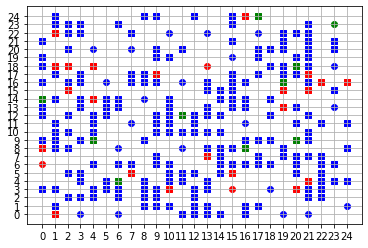

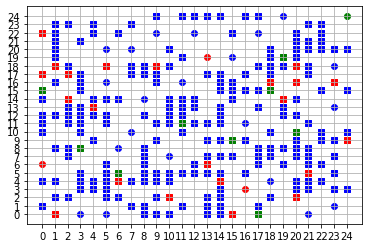

In [337]:
print('Test run_and_visualize_simulation()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.1
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

abm.run_and_visualize_simulation(2)

In [338]:
print('All tests pass for ABM class.')

All tests pass for ABM class.


## Run Simulation test

In [29]:
def run_simulations( num_simulations, 
                     num_steps, 
                     world_size, 
                     num_agents, 
                     num_infected, 
                     percent_distancing, 
                     percent_mask, 
                     percent_vaccinated):
    '''
    Runs full simulation a given number of times,
    then returns a list of simulation results in
    which each element in the list is the list of
    metric counts captured during a single simulation.
    '''
    
    sim_counts = [] # stores count sets for every simulation run
    
    for i in range(num_simulations):
        
        # set up model
        model = ABM(world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated)
        
        # run simulation and collect metrics
        counts = model.run_simulation(num_steps)
        
        # add metric set to simulation manager
        sim_counts.append(counts)
    
    return sim_counts

        
def plot_simulation_results(num_steps, sim_counts, debug=False):
    '''
    Uses results of each simulation run to calculate
    mean and standard deviation of the count for each 
    staus for each day in the simulation.
    
    Plots the results.
    '''

    # plot the results
    statusColors = {'R': 'r', 'S': 'b', 'I': 'g', 'Q': 'k', 'D': 'm'}
    fig, ax = plt.subplots(figsize=(20, 10))
    x = list(range(num_steps+1))

    # for each status
    for status in ['R', 'S', 'I', 'Q', 'D']:
        avgs = []
        errs = []
        if debug:
            print(status)
        
        # for each day in simulation
        for j in range(num_steps+1):

            # create an array of each separate count 
            # of a given status for a given day in each simulation run
            stats = np.array([counts[j][status] for counts in sim_counts])
            if debug:
                print(stats) # for debugging

            # calculate mean and standard deviation of each status for a given day over all simulation runs
            # store results to plot
            avgs.append(np.mean(stats))
            errs.append(np.std(stats))

        ax.errorbar(x,avgs,yerr=errs, fmt=statusColors[status], label=status)

    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
def get_metrics(num_steps, sim_counts, step):
    '''
    Calculates and returns metrics for a single time 
    step using given total steps and sim_counts.
    '''
    
    results = []
    for status in ['R', 'S', 'I', 'Q', 'D']:
        avgs = []
        errs = []
        
        # for each day in simulation
        for j in range(num_steps+1):

            # create an array of each separate count 
            # of a given status for a given day in each simulation run
            stats = np.array([counts[j][status] for counts in sim_counts])

            # calculate mean and standard deviation of each status for a given day over all simulation runs
            # store results to plot
            avgs.append(np.mean(stats))
            errs.append(np.std(stats))
        
        results.append((status, avgs[step], errs[step]))
    
    return results
    

In [21]:
print('Test run_simulations()')

num_simulations=3
num_steps=2
world_size=25
num_agents=250
num_infected=10
percent_distancing=0.1
percent_mask=0.25
percent_vaccinated=0.1

sim_counts = run_simulations(num_simulations, 
                             num_steps, 
                             world_size, 
                             num_agents, 
                             num_infected, 
                             percent_distancing, 
                             percent_mask, 
                             percent_vaccinated)
sim_counts

Test run_simulations()


[[{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 13, 'S': 212, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 15, 'S': 210, 'Q': 0}],
 [{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 15, 'S': 210, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 21, 'S': 204, 'Q': 0}],
 [{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 12, 'S': 213, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 23, 'S': 202, 'Q': 0}]]

In [28]:
print('Test get_metrics()')

num_steps=2
get_metrics(num_steps, sim_counts, 1)

Test get_metrics()


[('R', 25.0, 0.0),
 ('S', 211.66666666666666, 1.247219128924647),
 ('I', 13.333333333333334, 1.247219128924647),
 ('Q', 0.0, 0.0),
 ('D', 0.0, 0.0)]

Test plot_simulation_results()
R
[25 25 25]
[25 25 25]
[25 25 25]
S
[215 215 215]
[210 212 210]
[207 211 207]
I
[10 10 10]
[15 13 15]
[18 14 18]
Q
[0 0 0]
[0 0 0]
[0 0 0]
D
[0 0 0]
[0 0 0]
[0 0 0]


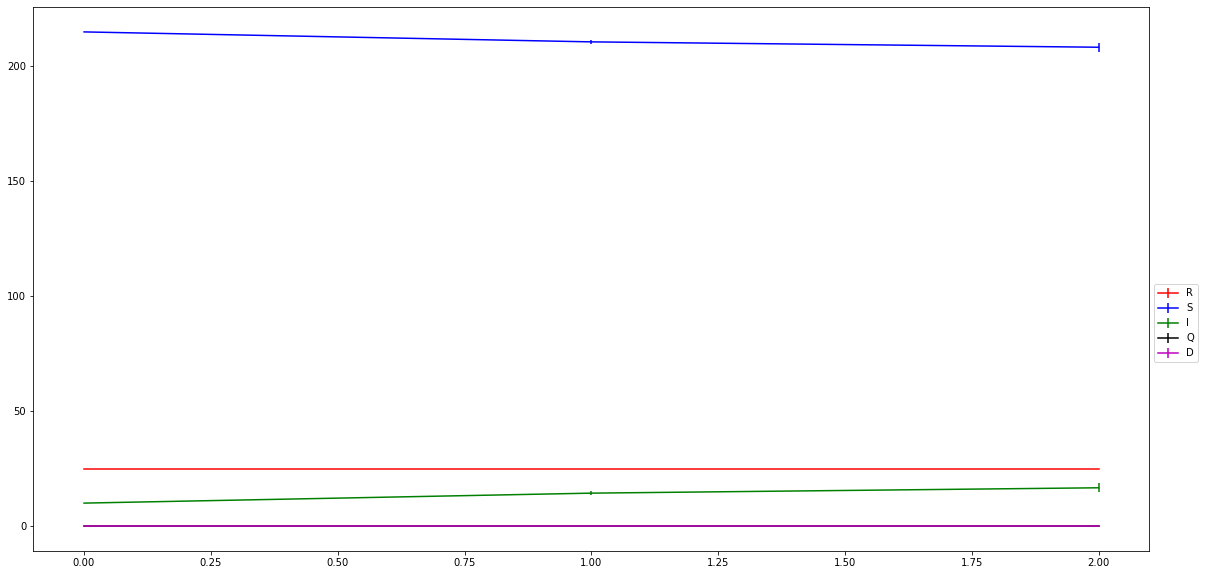

In [59]:
print('Test plot_simulation_results()')

num_steps=2

plot_simulation_results(num_steps, sim_counts,True)


## 1.2 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 

* 5 infected agents (I), the rest are susceptible (S)
* 0% of agents wear masks
* 0% of agents practice physical distancing

Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard error bars. 
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 


### Answers to questions

What is the final value of R? 
**R=231.5**

What is the peak number of active cases (I+Q)? 
**The peak is 58.1+ 110.9 = 169 (day 18)**

How many days does it take for the virus to go extinct (i.e. I+Q=0)? 
**The virus goes extinct after 57 days. The number of infected never goes below 2.7, so I treated that as zero for the purposes of this question.**



In [30]:
%%time

num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.0

# run simulations
sim_counts_1_2 = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 17s, sys: 285 ms, total: 1min 17s
Wall time: 1min 18s


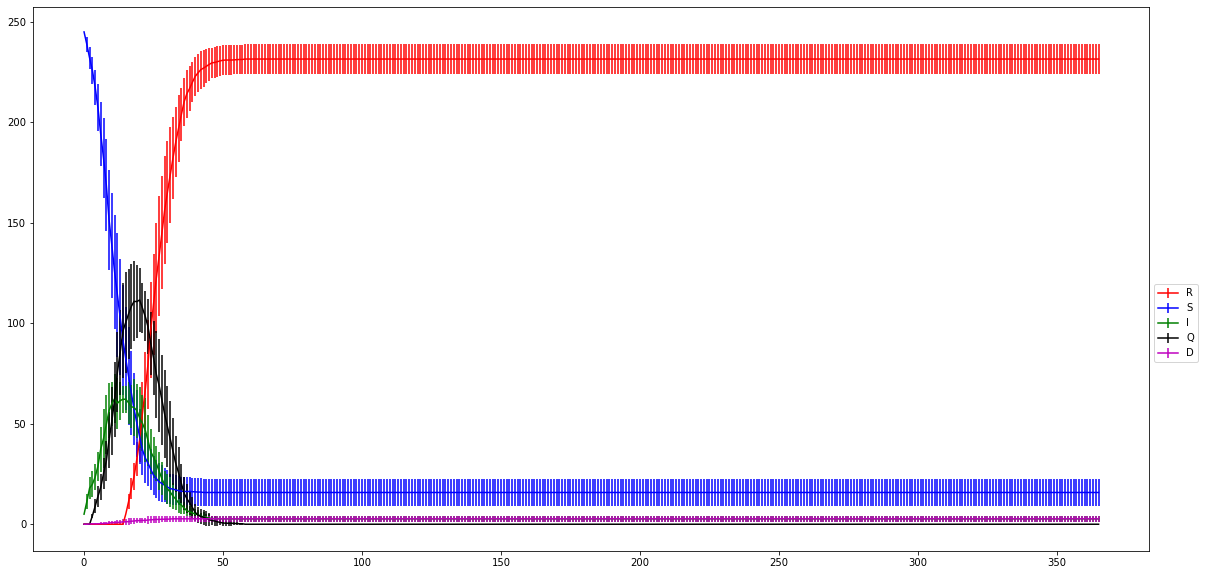

In [31]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_2)

### Calculating answers to questions

In [32]:
sim_counts_1_2

get_metrics(num_steps, sim_counts_1_2, 365)

[('R', 231.5, 7.242237223399963),
 ('S', 15.8, 6.838128398911504),
 ('I', 2.7, 1.4866068747318506),
 ('Q', 0.0, 0.0),
 ('D', 2.7, 1.4866068747318506)]

In [96]:
for each in range(56,61):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_2, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

56
[('R', 231.3, 7.280796659706959), ('S', 15.8, 6.838128398911504), ('I', 2.7, 1.4866068747318506), ('Q', 0.2, 0.6000000000000001), ('D', 2.7, 1.4866068747318506)] 2.9000000000000004
57
[('R', 231.3, 7.280796659706959), ('S', 15.8, 6.838128398911504), ('I', 2.7, 1.4866068747318506), ('Q', 0.2, 0.6000000000000001), ('D', 2.7, 1.4866068747318506)] 2.9000000000000004
58
[('R', 231.5, 7.242237223399963), ('S', 15.8, 6.838128398911504), ('I', 2.7, 1.4866068747318506), ('Q', 0.0, 0.0), ('D', 2.7, 1.4866068747318506)] 2.7
59
[('R', 231.5, 7.242237223399963), ('S', 15.8, 6.838128398911504), ('I', 2.7, 1.4866068747318506), ('Q', 0.0, 0.0), ('D', 2.7, 1.4866068747318506)] 2.7
60
[('R', 231.5, 7.242237223399963), ('S', 15.8, 6.838128398911504), ('I', 2.7, 1.4866068747318506), ('Q', 0.0, 0.0), ('D', 2.7, 1.4866068747318506)] 2.7


In [98]:
for each in range(15,20):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_2, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

15
[('R', 5.0, 0.0), ('S', 82.4, 25.671774383552066), ('I', 62.2, 6.705221845696084), ('Q', 100.4, 25.23965134466005), ('D', 1.2, 1.469693845669907)] 162.60000000000002
16
[('R', 11.1, 3.726929030716845), ('S', 73.8, 24.247886505837986), ('I', 60.5, 10.375451797391765), ('Q', 104.6, 22.597344976788758), ('D', 1.3, 1.6155494421403513)] 165.1
17
[('R', 17.8, 5.173006862551025), ('S', 65.3, 20.84250464795438), ('I', 58.5, 10.688779163215974), ('Q', 108.4, 20.99619013059274), ('D', 1.5, 1.5)] 166.9
18
[('R', 23.8, 6.80881781221968), ('S', 57.2, 17.85385112517745), ('I', 58.1, 14.334922392534953), ('Q', 110.9, 19.91707809895819), ('D', 1.6, 1.4966629547095764)] 169.0
19
[('R', 32.4, 8.511169132381285), ('S', 50.3, 16.727522231340778), ('I', 56.5, 13.418271125595876), ('Q', 110.8, 18.186808406094787), ('D', 1.8, 1.4000000000000001)] 167.3


## 1.3 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 


*   5 infected agents (I), the rest are susceptible (S)
*   p% of agents wear masks
*   p% of agents practice physical distancing

Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard error bars. 
What value of p reduces the final value of R to roughly half of the final value of R you obtained for part 1.2?
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 

### Answers to Questions

What value of p reduces the final value of R to roughly half of the final value of R you obtained for part 1.2?
**The final value of R for 1.2 was 232. A value of p=0.2, or 20% masked and distancing, results in a final R of R=125, which is almost half.**

What is the final value of R?
**R=125**

What is the peak number of active cases (I+Q)? 
**54.2+24.8=79 (day 14)**

How many days does it take for the virus to go extinct (i.e. I+Q=0)? 
**The virus goes extinct after 68 days. The number of infected never goes below 0.9, so I treat that as zero for infected.**

In [46]:
%%time

# five percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.05
percent_mask=0.05
percent_vaccinated=0.0

# run simulations
sim_counts_1_3a = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 24s, sys: 339 ms, total: 1min 25s
Wall time: 1min 25s


In [47]:
%%time

# ten percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.1
percent_mask=0.1
percent_vaccinated=0.0

# run simulations
sim_counts_1_3b = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 31s, sys: 356 ms, total: 1min 32s
Wall time: 1min 32s


In [48]:
%%time

# fifteen percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.15
percent_mask=0.15
percent_vaccinated=0.0

# run simulations
sim_counts_1_3c = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 38s, sys: 384 ms, total: 1min 38s
Wall time: 1min 39s


In [49]:
%%time

# twenty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.2
percent_mask=0.2
percent_vaccinated=0.0

# run simulations
sim_counts_1_3d = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 45s, sys: 348 ms, total: 1min 45s
Wall time: 1min 47s


In [50]:
%%time

# twenty-five percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.25
percent_mask=0.25
percent_vaccinated=0.0

# run simulations
sim_counts_1_3e = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 48s, sys: 385 ms, total: 1min 49s
Wall time: 1min 49s


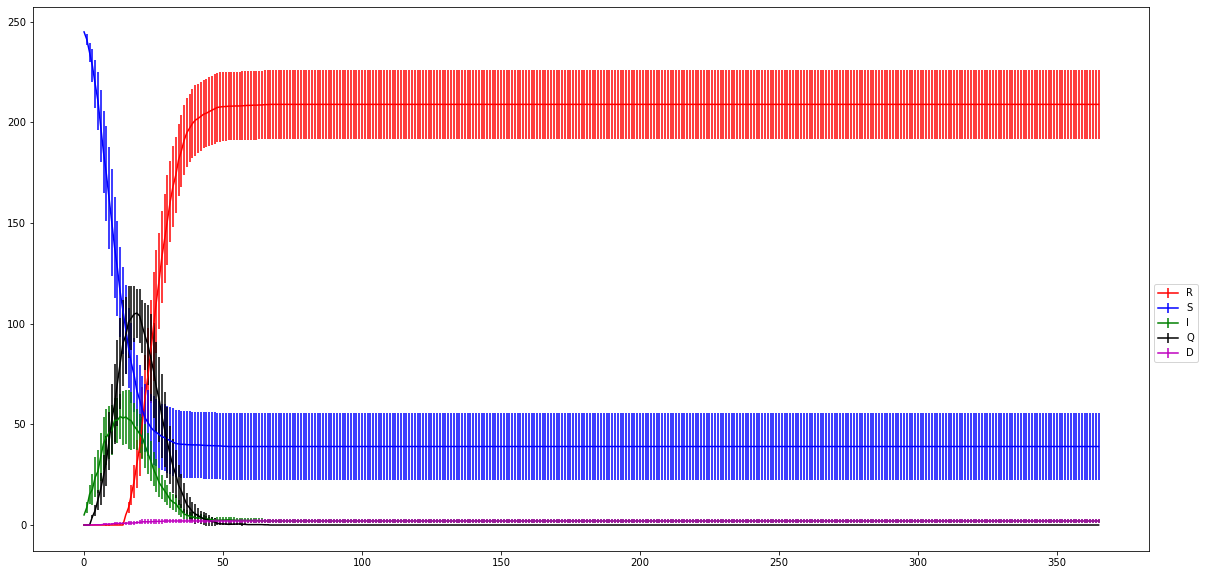

In [51]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3a)

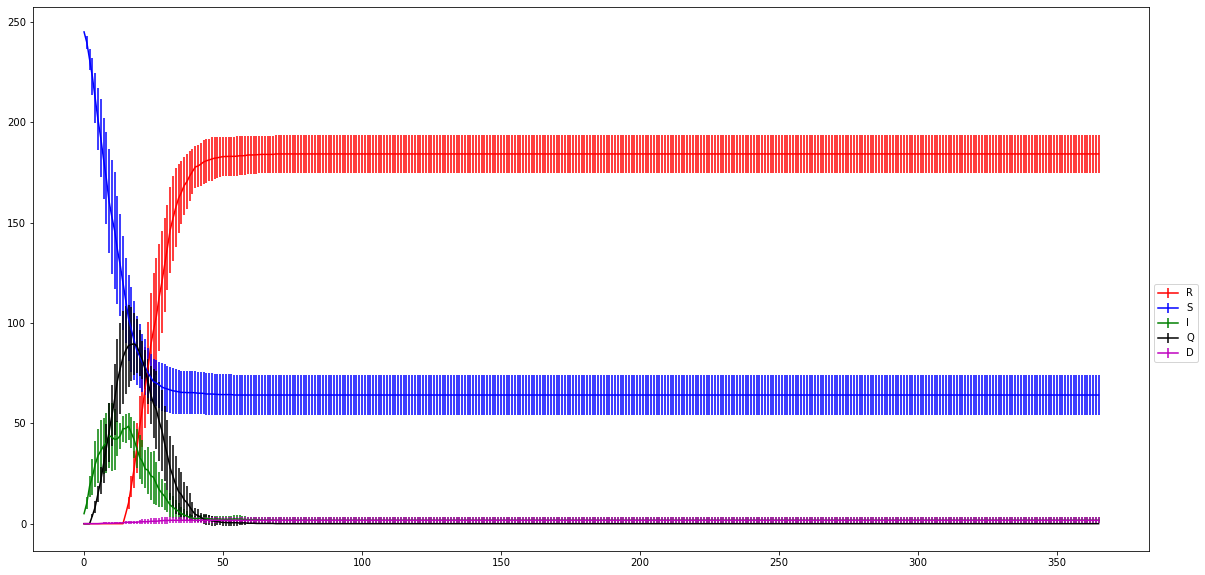

In [52]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3b)

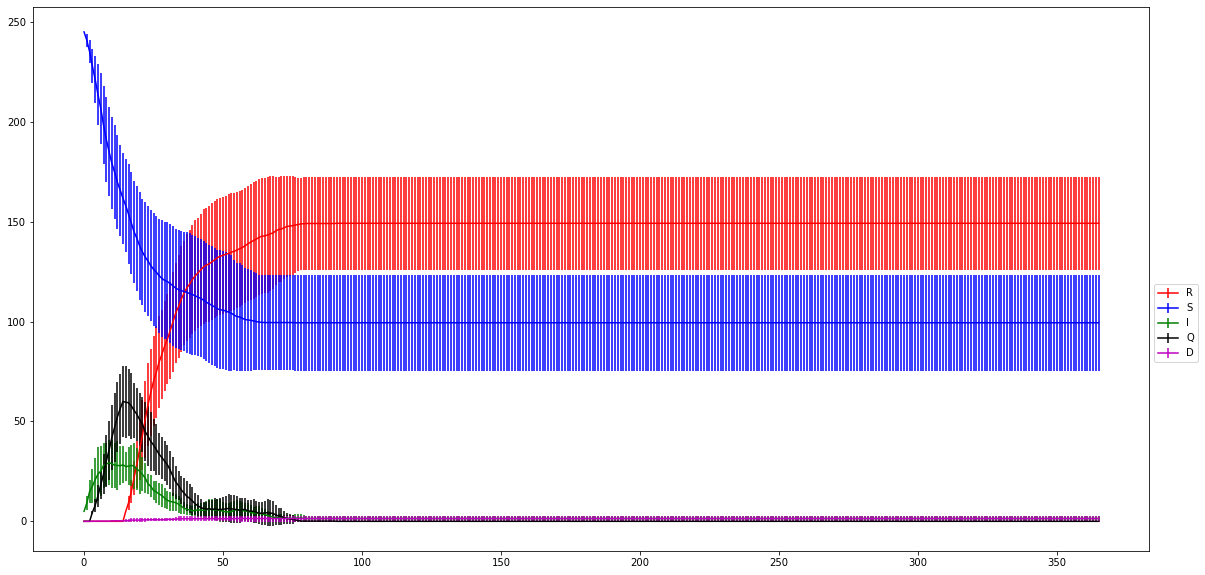

In [53]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3c)

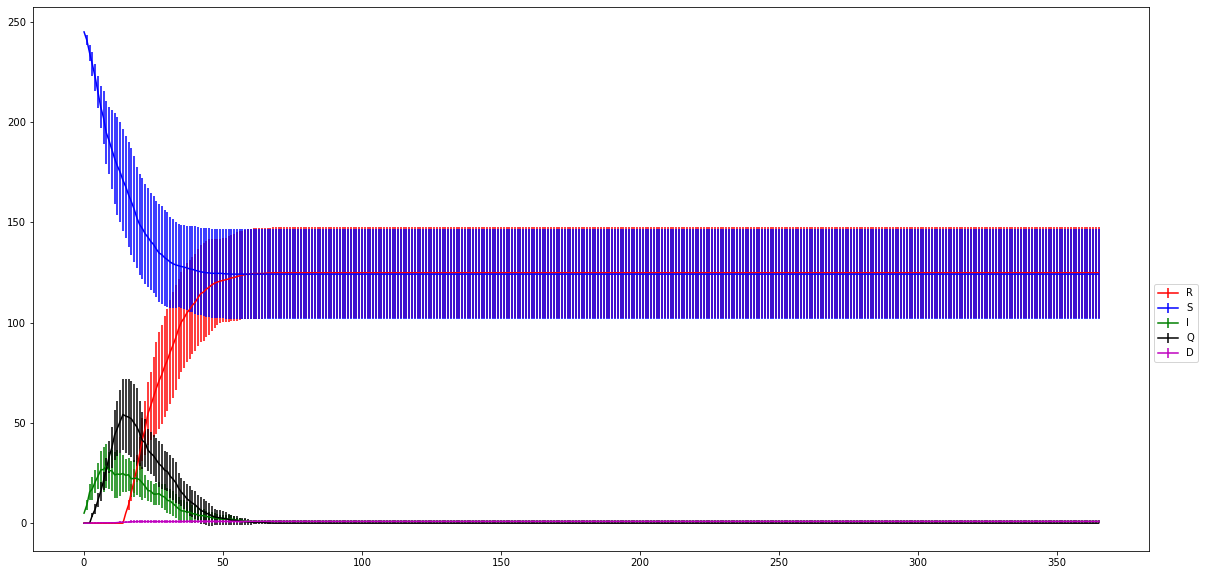

In [54]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3d)

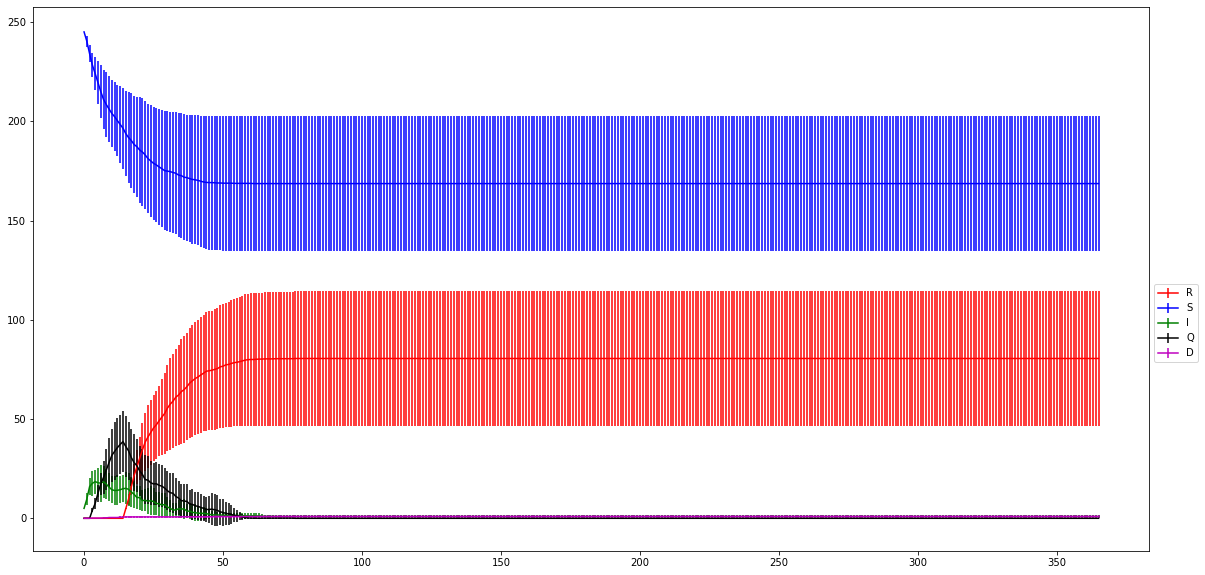

In [55]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3e)

### Calculating answers to questions

In [100]:
get_metrics(num_steps, sim_counts_1_3c, 365) # 149
get_metrics(num_steps, sim_counts_1_3e, 365) # 81
get_metrics(num_steps, sim_counts_1_3d, 365) # 125

[('R', 124.9, 22.669142021699898),
 ('S', 124.2, 22.511330480449175),
 ('I', 0.9, 0.7000000000000001),
 ('Q', 0.0, 0.0),
 ('D', 0.9, 0.7000000000000001)]

In [99]:
# max is day 14

for each in range(13,18):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_3d, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

13
[('R', 0.0, 0.0), ('S', 175.0, 24.879710609249457), ('I', 24.3, 10.555093557141026), ('Q', 50.7, 15.818027689949211), ('D', 0.5, 0.5)] 75.0
14
[('R', 0.0, 0.0), ('S', 171.0, 25.365330670030698), ('I', 24.8, 9.097252332435326), ('Q', 54.2, 17.73020022447575), ('D', 0.5, 0.5)] 79.0
15
[('R', 5.0, 0.0), ('S', 167.8, 25.451129640941282), ('I', 23.8, 8.121576201698781), ('Q', 53.4, 18.569868066305695), ('D', 0.5, 0.5)] 77.2
16
[('R', 9.1, 2.3853720883753127), ('S', 163.8, 26.175561121015154), ('I', 24.2, 8.207313811473277), ('Q', 52.9, 18.77471704180918), ('D', 0.6, 0.66332495807108)] 77.1
17
[('R', 15.4, 4.2708313008125245), ('S', 160.4, 26.560120481654444), ('I', 22.1, 8.814193099768124), ('Q', 52.1, 18.97076698502198), ('D', 0.7, 0.6403124237432849)] 74.2


In [101]:
for each in range(60,70):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_3d, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

60
[('R', 124.3, 22.347483079756433), ('S', 124.2, 22.511330480449175), ('I', 1.0, 0.7745966692414834), ('Q', 0.5, 1.2041594578792296), ('D', 0.9, 0.7000000000000001)] 1.5
61
[('R', 124.5, 22.45996438109375), ('S', 124.2, 22.511330480449175), ('I', 0.9, 0.7000000000000001), ('Q', 0.4, 0.9165151389911681), ('D', 0.9, 0.7000000000000001)] 1.3
62
[('R', 124.5, 22.45996438109375), ('S', 124.2, 22.511330480449175), ('I', 0.9, 0.7000000000000001), ('Q', 0.4, 0.9165151389911681), ('D', 0.9, 0.7000000000000001)] 1.3
63
[('R', 124.5, 22.45996438109375), ('S', 124.2, 22.511330480449175), ('I', 0.9, 0.7000000000000001), ('Q', 0.4, 0.9165151389911681), ('D', 0.9, 0.7000000000000001)] 1.3
64
[('R', 124.5, 22.45996438109375), ('S', 124.2, 22.511330480449175), ('I', 0.9, 0.7000000000000001), ('Q', 0.4, 0.9165151389911681), ('D', 0.9, 0.7000000000000001)] 1.3
65
[('R', 124.6, 22.521989254948153), ('S', 124.2, 22.511330480449175), ('I', 0.9, 0.7000000000000001), ('Q', 0.3, 0.6403124237432849), ('D', 0.

## 1.4 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 


*   5 infected agents (I), p% of agents have been vaccinated (i.e., start in state R), the rest are susceptible (S)
*   0% of agents wear masks
*   0% of agents practice physical distancing


Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard errors. 
What value of p reduces the peak number of active cases (I+Q) to roughly half of the final value of (I+Q) you obtained for part 1.2?
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 

### Answers to Questions

What value of p reduces the peak number of active cases (I+Q) to roughly half of the final value of (I+Q) you obtained for part 1.2?
**The peak number of cases in 1.2 was 169. Half of that would be about 85. The value of p=0.2 or 20% gives a peak number of active cases as 87 (day 19).**


What is the final value of R?
**R=206.1**


What is the peak number of active cases (I+Q)? 
**The peak number is 28.8+57.6=87**


How many days does it take for the virus to go extinct (i.e. I+Q=0)? 
**The virus went extinct after 74 days. Number of infected never goes below 0.8, so I treat that as zero for infected.**

In [75]:
%%time

# ten percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.1

# run simulations
sim_counts_1_4a = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 18s, sys: 274 ms, total: 1min 18s
Wall time: 1min 19s


In [76]:
%%time

# twenty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.2

# run simulations
sim_counts_1_4b = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 18s, sys: 270 ms, total: 1min 18s
Wall time: 1min 18s


In [77]:
%%time

# thirty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.3

# run simulations
sim_counts_1_4c = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 16s, sys: 279 ms, total: 1min 17s
Wall time: 1min 17s


In [81]:
%%time

# fourty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.4

# run simulations
sim_counts_1_4d = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 16s, sys: 266 ms, total: 1min 17s
Wall time: 1min 17s


In [82]:
%%time

# fifty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.5

# run simulations
sim_counts_1_4e = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 16s, sys: 321 ms, total: 1min 17s
Wall time: 1min 17s


In [83]:
%%time

# sixty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.6

# run simulations
sim_counts_1_4f = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 16s, sys: 249 ms, total: 1min 16s
Wall time: 1min 16s


In [88]:
%%time

# seventy percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.7

# run simulations
sim_counts_1_4g = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 16s, sys: 259 ms, total: 1min 16s
Wall time: 1min 17s


In [89]:
%%time

# eighty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.8

# run simulations
sim_counts_1_4h = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 20s, sys: 306 ms, total: 1min 20s
Wall time: 1min 21s


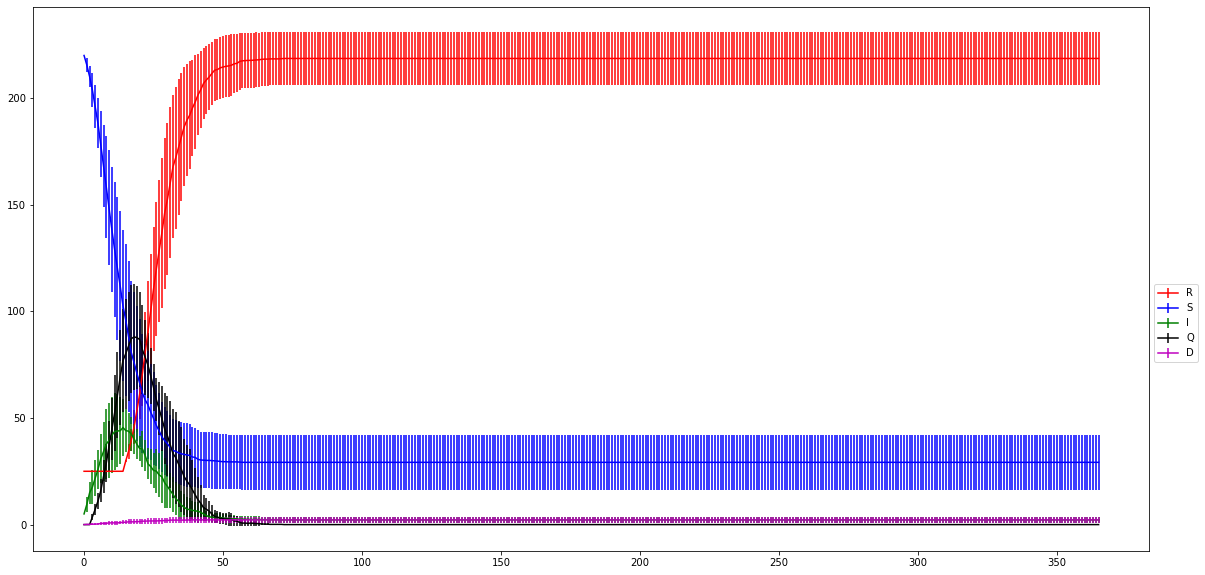

In [78]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4a)

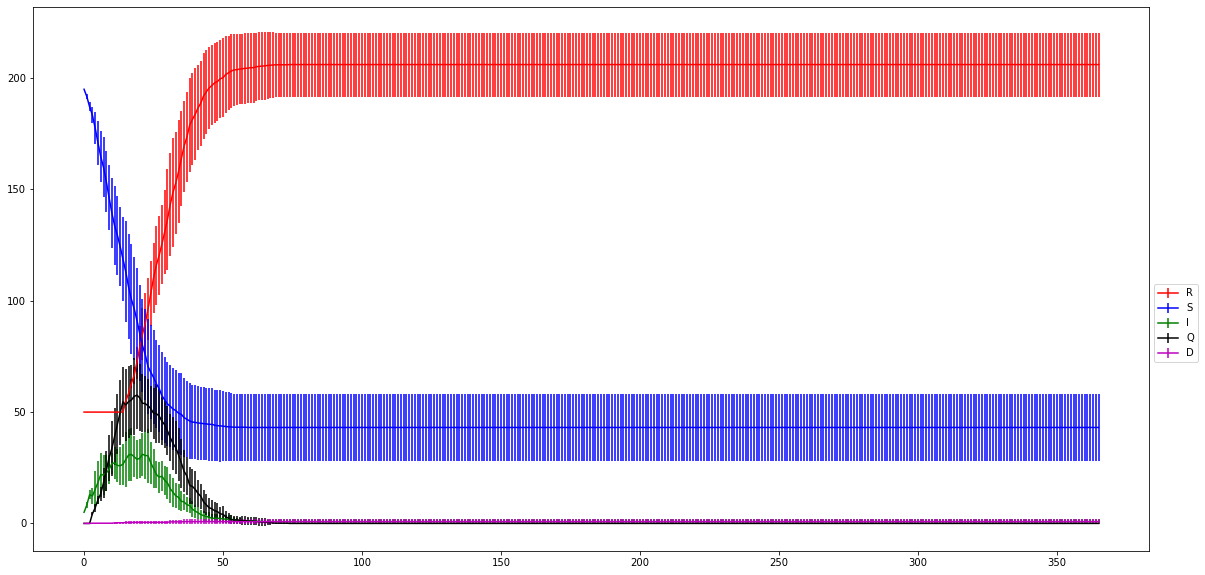

In [79]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4b)

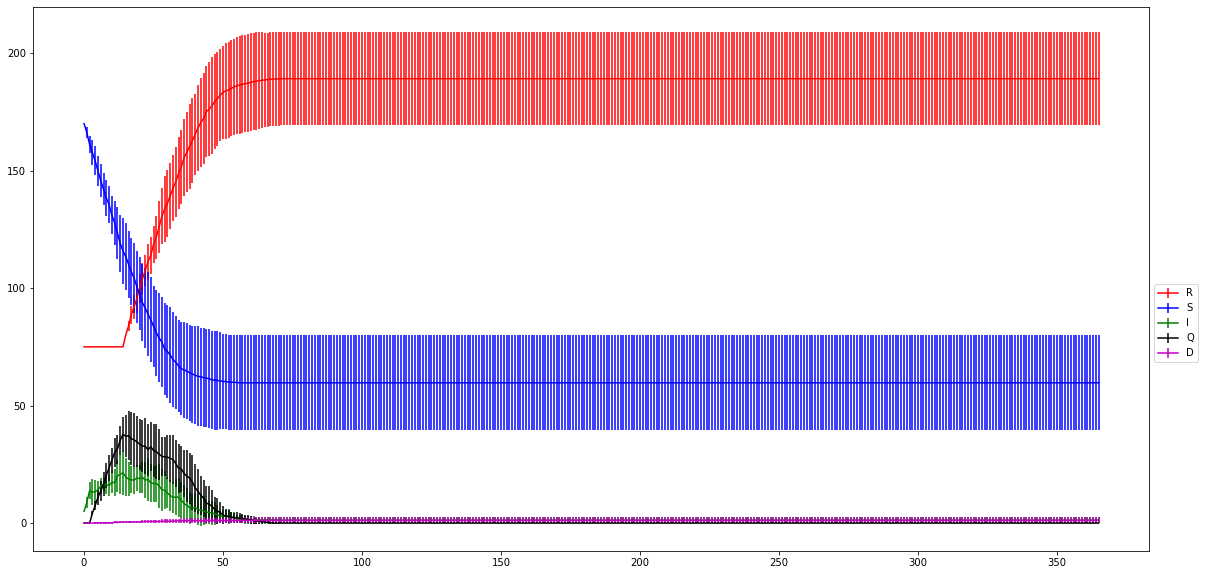

In [80]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4c)

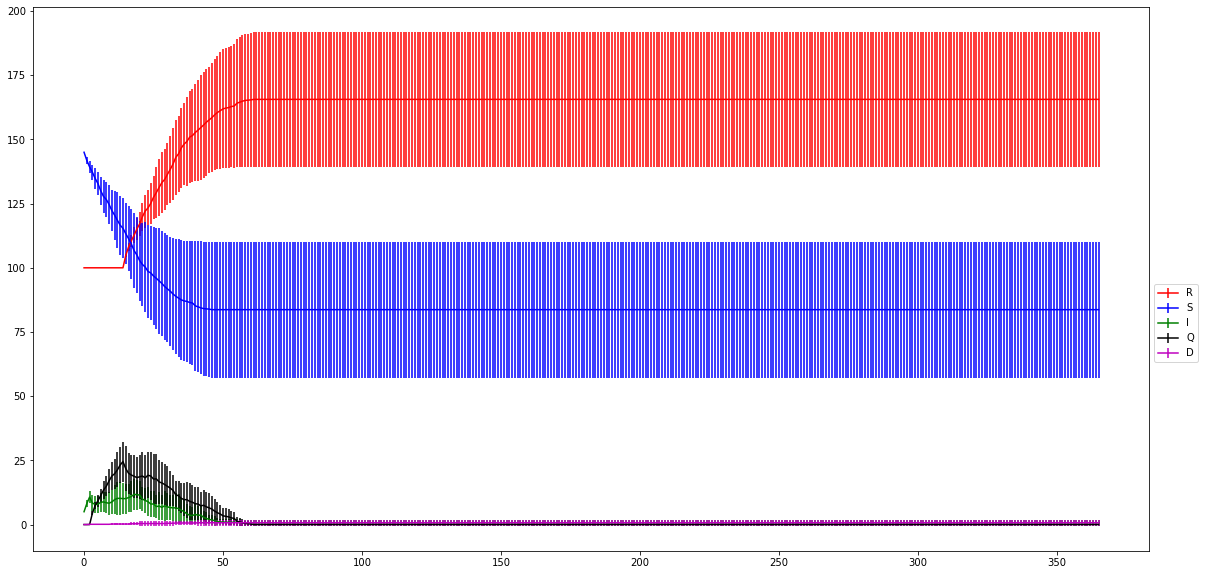

In [84]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4d)

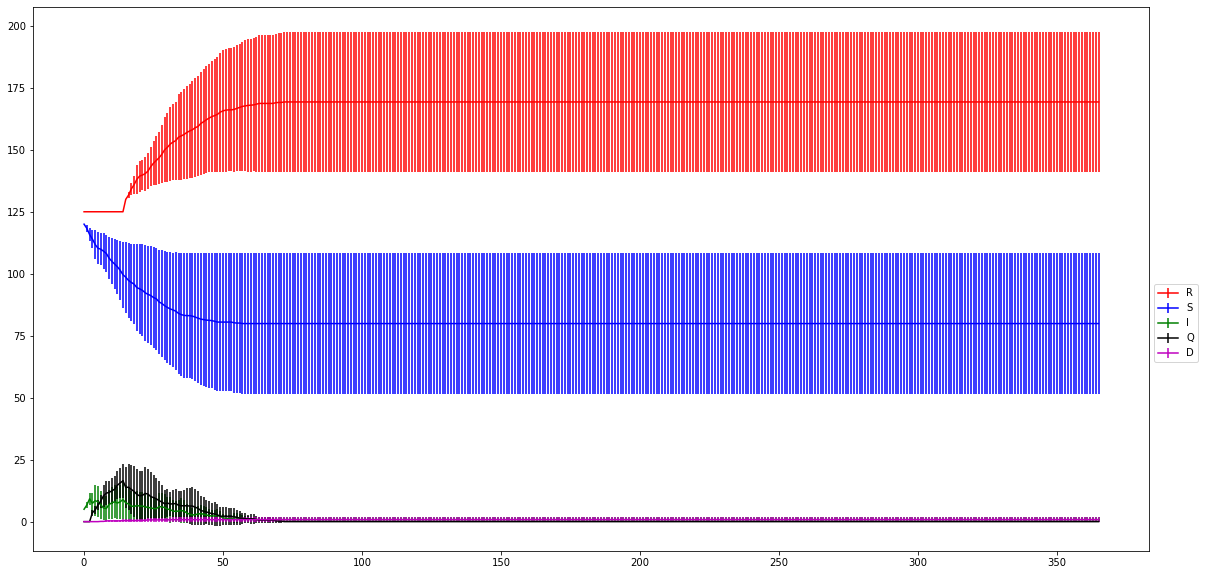

In [85]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4e)

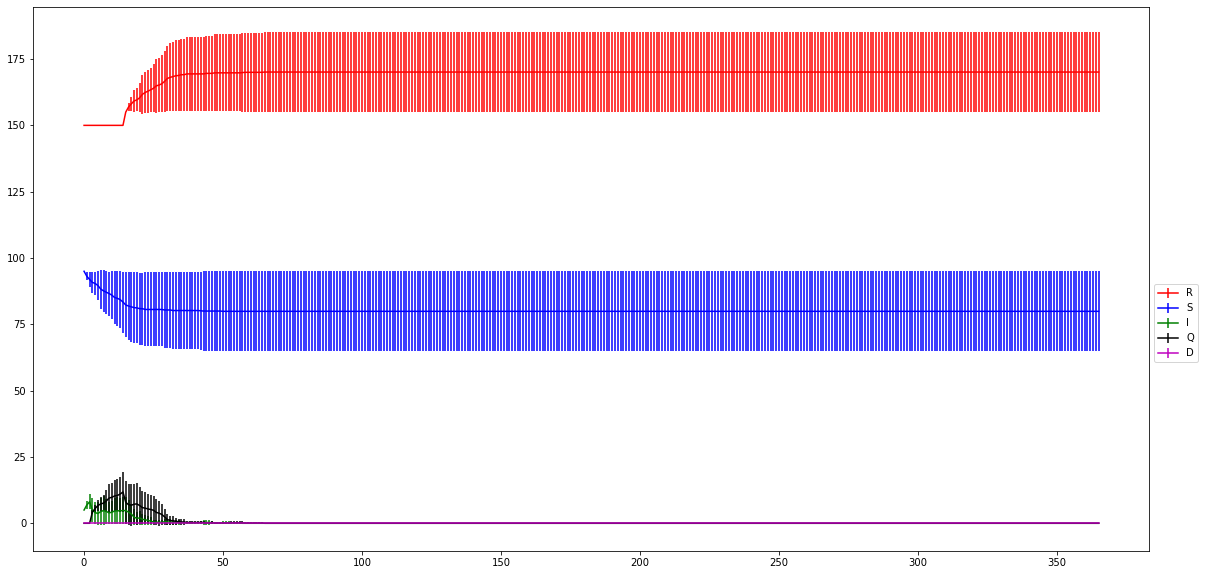

In [86]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4f)

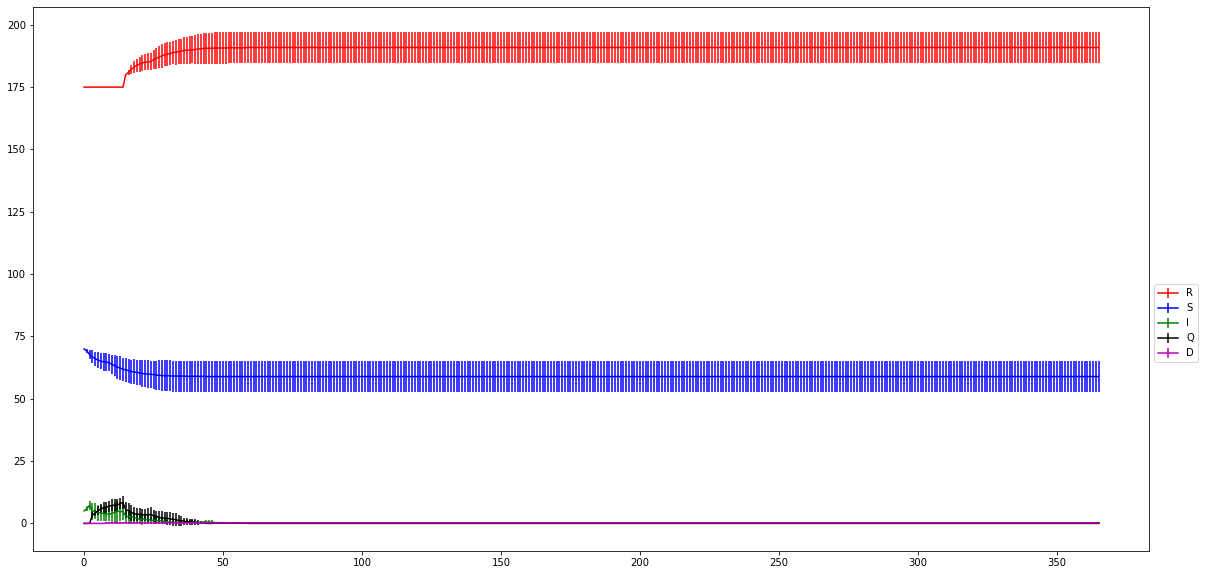

In [90]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4g)

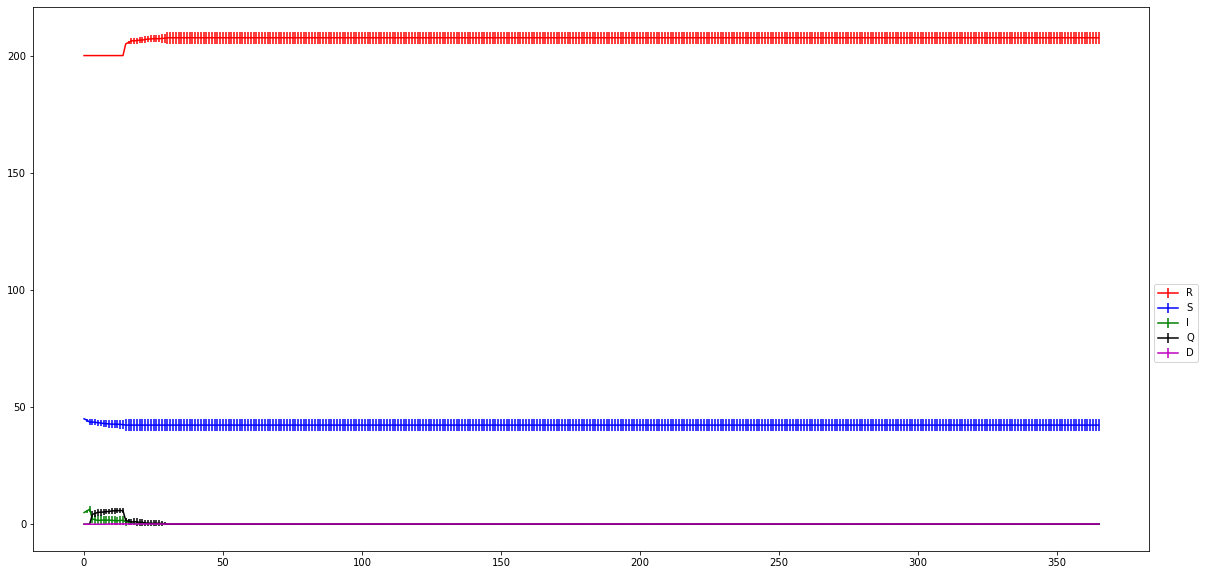

In [91]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4h)

### Calculating answers to questions

In [94]:
print(get_metrics(num_steps, sim_counts_1_4a, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4b, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4c, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4d, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4e, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4f, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4g, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4h, 365)[0])
print()

('R', 218.6, 12.451505933018705)

('R', 206.1, 14.362799170078235)

('R', 189.1, 19.902009948746382)

('R', 165.6, 26.276224995230955)

('R', 169.3, 28.249070781177917)

('R', 170.1, 15.129111011556494)

('R', 190.9, 6.252199612936235)

('R', 207.6, 2.4979991993593593)



In [95]:
# max is day 19
for each in range(17,21):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_4b, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

17
[('R', 62.8, 1.9390719429665315), ('S', 100.8, 24.587801853764805), ('I', 31.0, 11.8911731969558), ('Q', 55.4, 15.704776343520464), ('D', 0.4, 0.66332495807108)] 86.4
18
[('R', 66.4, 3.6660605559646715), ('S', 96.6, 23.264565330132434), ('I', 30.0, 9.252026804976301), ('Q', 57.0, 17.326280616450838), ('D', 0.5, 0.6708203932499369)] 87.0
19
[('R', 72.2, 7.2636079189339515), ('S', 91.4, 23.247365442131287), ('I', 28.8, 8.681013765684282), ('Q', 57.6, 15.363593329686905), ('D', 0.5, 0.6708203932499369)] 86.4
20
[('R', 78.8, 9.99799979995999), ('S', 85.5, 21.676023620581336), ('I', 29.2, 8.795453370918409), ('Q', 56.5, 14.928161306738348), ('D', 0.5, 0.6708203932499369)] 85.7


In [102]:
# max is day 19
for each in range(50,75):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_4b, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

50
[('R', 200.2, 17.792133093027378), ('S', 43.7, 15.862219264655245), ('I', 2.0, 1.4832396974191326), ('Q', 4.1, 3.753664875824692), ('D', 0.8, 0.9797958971132713)] 6.1
51
[('R', 201.7, 17.181676286090365), ('S', 43.5, 15.56438241627338), ('I', 1.9, 1.7), ('Q', 2.9, 2.7367864366808017), ('D', 0.8, 0.9797958971132713)] 4.8
52
[('R', 202.4, 16.523922052587878), ('S', 43.4, 15.4220621189256), ('I', 1.8, 1.8330302779823362), ('Q', 2.4, 2.2449944320643644), ('D', 0.8, 0.9797958971132713)] 4.2
53
[('R', 203.2, 16.412190591142913), ('S', 43.3, 15.284305676084864), ('I', 1.8, 1.8330302779823362), ('Q', 1.7, 1.9519221295943134), ('D', 0.8, 0.9797958971132713)] 3.5
54
[('R', 203.7, 16.050233643159217), ('S', 43.2, 15.151237573214937), ('I', 1.6, 1.4966629547095764), ('Q', 1.5, 1.6881943016134133), ('D', 0.8, 0.9797958971132713)] 3.1
55
[('R', 203.8, 15.904716281656833), ('S', 43.2, 15.151237573214937), ('I', 1.4, 1.1135528725660044), ('Q', 1.6, 1.7435595774162695), ('D', 0.8, 0.9797958971132713

In [103]:
print(get_metrics(num_steps, sim_counts_1_4b, 365))

[('R', 206.1, 14.362799170078235), ('S', 43.1, 15.022982393652732), ('I', 0.8, 0.9797958971132713), ('Q', 0.0, 0.0), ('D', 0.8, 0.9797958971132713)]
